# Amazon Stock Price Prediction

Author: Pongthanat Buranachon

## 1. Project Overview

Stock price prediction is one of the most widely studied application of time series forcasting in finance.
In this project, we aim to analyze and forecast Amazon's historical stock prices(1997-2020) using statistical and machine learning approaches.

Amazon is one of the largest global company and e-commerce companies. It has experienced in sustantial growht and volatility over the years. This incident influenced by market expandsion and product innovations.

Understanding thers historical patterns provides valueable insighes into volatility, which is essential for investors  to anticipate market movements.

This project focuses on:

- Exploratory Data Analysis (EDA): identifying long-term trends, price fluctuations, and trading volume dynamics.

- Stationarity and Decomposition: examining whether the series exhibits consistent patterns over time.

- Forecasting Models: implementing classical methods such as ARIMA / SARIMA and advanced approaches LSTM neural networks.

- Model Evaluation: comparing forecast accuracy using metrics such as RMSE, MAE, and MAPE.

---

## 2. Data Overview

The dataset contains Amazon’s historical stock market data ranging from 1997 to 2020, capturing over two decades of trading activity.

It includes key financial indicators such as Open, High, Low, Close, Adjusted Close, and Volume.

This section provides an initial exploration of the dataset to understand its structure, completeness, and key characteristics.

In [87]:
#import necessary libraries
import os
import re
import itertools
from datetime import datetime, timedelta
import random
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import math

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs, nsdiffs

from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

In [88]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("salmanfaroz/amazon-stock-price-1997-to-2020")
print(f"Dataset downloaded to: {path}")

Dataset downloaded to: C:\Users\USER\.cache\kagglehub\datasets\salmanfaroz\amazon-stock-price-1997-to-2020\versions\1


In [89]:
# List files in the dataset directory
print(os.listdir(path))

['Amazon.csv']


In [90]:
# Load the dataset
df = pd.read_csv(os.path.join(path,'Amazon.csv'),index_col='Date',parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.438,2.500,1.927,1.958,1.958,72156000
1997-05-16,1.969,1.979,1.708,1.729,1.729,14700000
1997-05-19,1.760,1.771,1.625,1.708,1.708,6106800
1997-05-20,1.729,1.750,1.635,1.635,1.635,5467200
1997-05-21,1.635,1.646,1.375,1.427,1.427,18853200


In [91]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-27,3062.000,3098.000,3015.770,3055.210,3055.210,4170500
2020-07-28,3054.270,3077.090,2995.760,3000.330,3000.330,3126700
2020-07-29,3030.990,3039.160,2996.770,3033.530,3033.530,2974100
2020-07-30,3014.000,3092.000,3005.000,3051.880,3051.880,6128300
2020-07-31,3244.000,3246.820,3151.000,3164.680,3164.680,8085500


In [92]:
# Function to provide an overview of the dataframe
def data_overview(dataframe):
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    print("="*60)
    print("Dataframe Shape:")
    print(f"rows: {dataframe.shape[0]}, columns: {dataframe.shape[1]}")

    print("="*60)
    print("\nDataframe Info:")
    print(dataframe.info())

    print("="*60)
    print("\nDataframe Description:")
    print(dataframe.describe())
    
    print("="*60)
    print("\nMissing Values in Each Column:")
    print(dataframe.isnull().sum())
    print("="*60)
    print("\nDuplicate Rows:",dataframe.duplicated().sum())

In [93]:
data_overview(df)

Dataframe Shape:
rows: 5842, columns: 6

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5842 entries, 1997-05-15 to 2020-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5842 non-null   float64
 1   High       5842 non-null   float64
 2   Low        5842 non-null   float64
 3   Close      5842 non-null   float64
 4   Adj Close  5842 non-null   float64
 5   Volume     5842 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 319.5 KB
None

Dataframe Description:
          Open     High      Low    Close  Adj Close        Volume
count 5842.000 5842.000 5842.000 5842.000   5842.000      5842.000
mean   372.707  376.921  368.115  372.747    372.747   7519047.877
std    585.572  591.766  578.661  585.608    585.608   7282682.646
min      1.406    1.448    1.312    1.396      1.396    487200.000
25%     37.955   38.548   37.208   37.927     37.927   3684900.000
50%     83.429  

The data set contains **5,842** records of Amazon stock from May 1997 to july 20w0 with 6 key numerical variables: `Open`,`High`,`Low`,`Close`,`Adj Close` and `Volume`.

All columns are complete with no missing or duplicate values.

Key Observations:

- Stock price range from **$1.39** to **$3,200**, indicating a ripid growth ove two decades.

- The mean closing price is about **$372.74**, with a large standard deviation of $585.

- Trading volume varies from **0.5 million** to over **104 million** shares per day.

---


## 3. Exploratory Data Analysis

### 3.1 Time- Series Visualization

In this section,The historical closing prices of Amazon stock are visualized to understand overall growth trends and volatility over time.

- Plot the closing prive over time to visualize growth and volatility.

- Add rolling averages to smooth short-term fluctuation.

- Include observations on key growth.

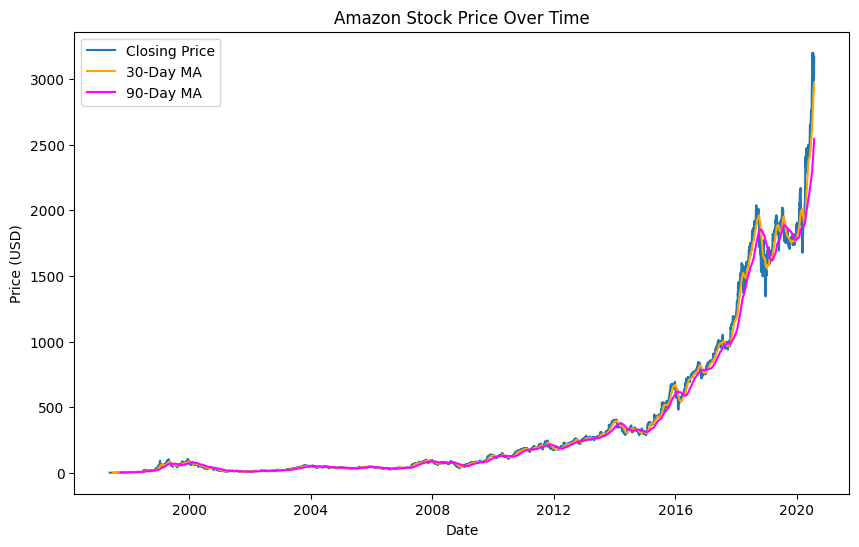

In [94]:
# Plotting the closing price over time to visualize growth and volatility
plt.figure(figsize=(10,6))
plt.plot(df['Close'],label = 'Closing Price')
plt.plot(df['Close'].rolling(window=30).mean(),label='30-Day MA',color='orange')
plt.plot(df['Close'].rolling(window=90).mean(),label='90-Day MA',color='magenta')
plt.title('Amazon Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

The plot above depicts Amazon's closing price from 18997 to 2020, along with it s 30 and 90 days moving average.

Key insights:

- Strong upward trend: It shows a consistent long term increase especially after 2010, reflecting in company's significant busness expandsion and dominance in e-commerce and cloud computing.

- Early years (1997-2008): Stock prices were relatively stable with minimal flutautions.

- Steep Growth (2015-2020): A sharp rise in stock value caused by the Amazon's global expandsion and AWS profitiability.

- Volatility Splike: Short term drop are visible around 2008 and early 2020.

- The moving averages confirm the upward trend.

---

### 3.2 Time- Series Decomposition

In this part, the stock’s closing price is decomposed into its underlying components — trend, seasonality, and residuals.

- Decompose the time series into **Trend, Seasonal, and Residuals**

- Interpret each components 


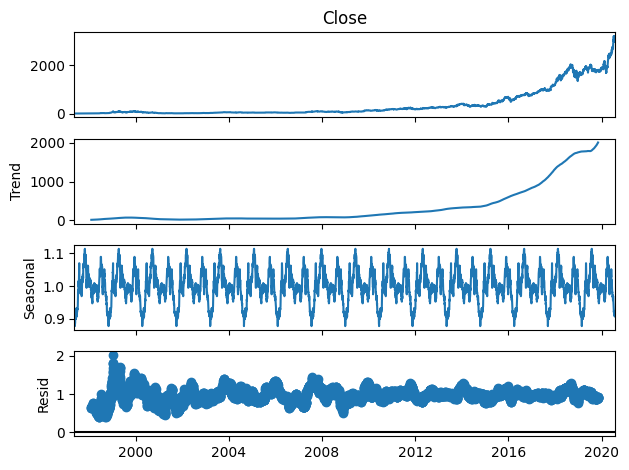

In [95]:
# Plot the seasonal decomposition of the closing price
res = seasonal_decompose(df['Close'], model='multiplicative', period=365)
res.plot()
plt.show()

The decomposition plot shows the trend, seasonality and residuals as above.

Key insights:

- **Trend Component**: The long term upward trend becomes noticeably after 2015, showing a strong and substantial growth in Amazon stock. The line steepens significanlty after 2018. This rise depicts an accelerated momentum.

- **Seasonal Component**: The seasonal pattern shows repeated cycle fluctuation. this suggest a consistent short term variation.

- **Residual Component**: The early period (1997-2003) shows higher volatality. After that the magintude gradually stabilizes. However, short busts are still visible througout the year, indicating that the market reacted to external factors such as global crises and earning announcements.

---

### 3.3 Residuals Analysis

Residuals is a part of time series that remains after removing trend and seasonality. By analyzing residuals, we can observe whether a model has captured information in the data.

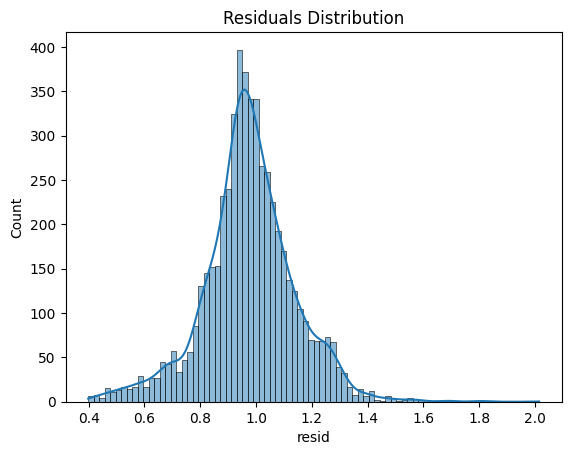

In [96]:
# Distribution of Residuals
residuals = res.resid.dropna()
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.show()

The histrogram shows that the residuals approximately normally distributed, centered around 1 qith a slight right skew. This indicates that the model erros are mostly random, ensuring the model reliability. However, the right skew depicts occasional large positive deviation, which occurs due to the short bursts of stock price spikes that does not explained by the model.

---

### 3.4 Correlation & Lag Relationships
In this section, we analyze how features and past values of stock are related to each other.

- Include the correlation heatmap of numerical variables.

- Plot ACF and PACF to study autocorrelation between lagged value of the closing price.

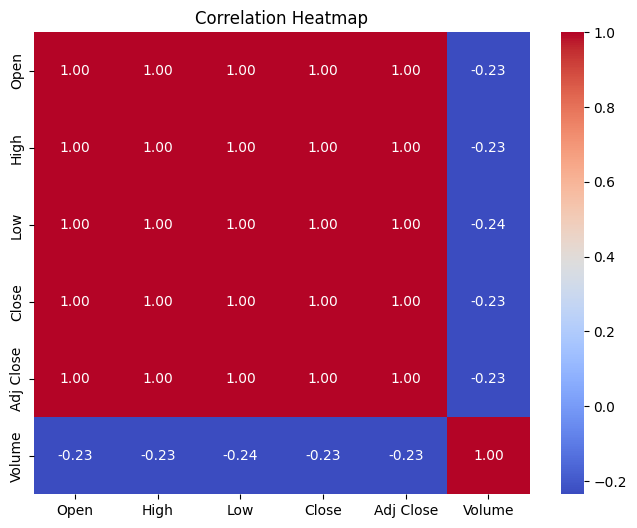

Adj Close    1.000
Low          1.000
High         1.000
Open         1.000
Volume      -0.234
Name: Close, dtype: float64


In [97]:
# Correlation Heatmap
corr = df.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Correlation of 'Close' with other features
print(corr['Close'].drop('Close').sort_values(ascending=False))

The **Open, High, Low, Close and Adj Close** prices have extreamely high positive correation of approximately **1** with each other. These prices variables move together daily since they represent different points of the same trading day.

The volume variable has a weak negative corrlelation of **- 0.23** with all price. This suggests that increased volume may occurs durning market correction.

Due to the multicolinearity, it is **generally best to opt one of the price** in the model.


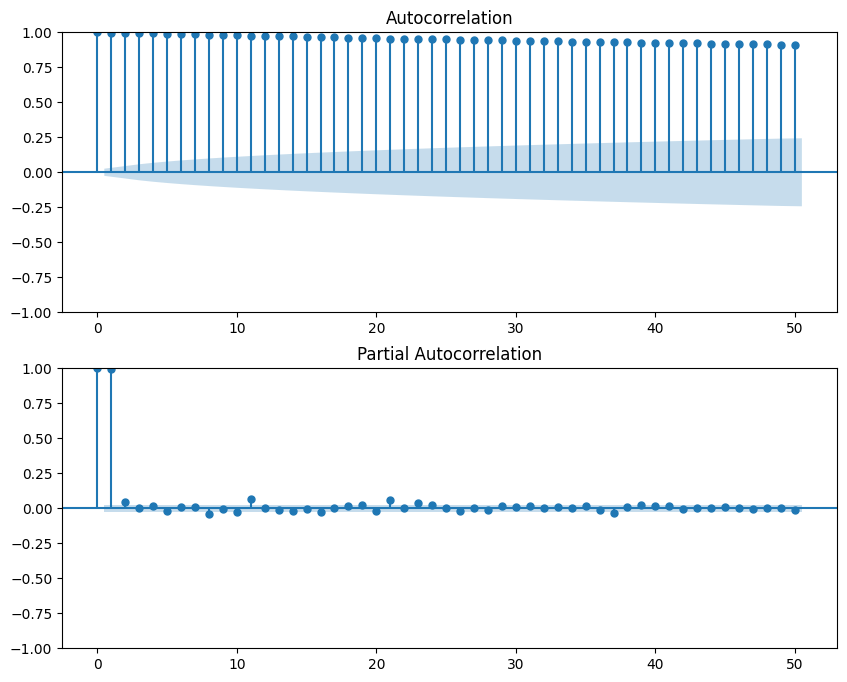

In [98]:
# ACF and PACF plots
fig, ax = plt.subplots(2,1, figsize=(10,8))
plot_acf(df['Close'], lags=50, ax=ax[0])
plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.show()

1. **Autocorrelation (ACF)**
- This ACF plot shows a gradual decay from 1 to 0.
- This pattern suggests that the series is non-stationary.
- The slow decay implied a strong trend component in the series.

2. **Partial Autocorrelation (PACF)**
- The PACF plot shows a significant spike in lag 1 ,followed by the sharp drop to near zero.
- This suggests that the model is an AR(1) process.

---

###  3.5 Statinarity Check

In this section, the time series is examined to determine whether the series is stantionary, meaning that its statistical properites remain constant overtime.

Stationary series is a key assumption in time series forcasting model such as ARIMA.

- Plot the rolling mean and standard deviation to visualize fluctuations overtime.

- Perform the Augmented Dickey Fuller test to verify the stationary
    - If $P < 0.05$, the series is considered to be stationary
    - if $P \ge 0.05$, the series exhibit a non stationary properties,requiring differencing to stabilize the mean and variance.



In [99]:
# ADF test function
def adf_test(series):

    # Perform Augmented Dickey-Fuller test

    if np.isnan(series[0]) == True:
        adf_result = adfuller(series.dropna())
        print("\n\n")
    else:
        adf_result = adfuller(series)
        print("\n\n")

    # adf result 
    print(f"Augmented Dickey-Fuller Test Results: {series.name}")
    print("="*60)

    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")

    for key, value in adf_result[4].items():
        print(f'Critical Value ({key}): {value:.2f}')

    if adf_result[1] <= 0.05:
        print("Conclusion: The series is stationary (reject H0)")
    else:
        print("Conclusion: The series is non-stationary (fail to reject H0)")
        print("\n")

    
    print("="*60)
    print(f"Autocorrelation and Partial Autocorrelation Plots: {series.name}")
    print("="*60)
    fig , ax = plt.subplots(2,1, figsize=(10,4))
    plot_acf(series, lags=50, ax=ax[0])
    plot_pacf(series, lags=50, ax=ax[1])

    ax[0].set_title('Autocorrelation Function (ACF)',fontsize = 12)
    ax[1].set_title('Partial Autocorrelation Function (PACF)',fontsize = 12)

    for axes in ax:
        axes.set_xlim(0,50)
        axes.grid(True,linestyle='--',alpha=0.7)
    
    plt.tight_layout(pad=2.0)
    plt.show()

This function outputs:

- The ADF statistics
- P-value
- Critical values at different significance levels (1% ,5% and 10%)
- Clear conclusion whether the series is stationary.
- ACF and PACF plot

In [100]:
# Create transformed columns for analysis
df['log_Close'] = np.log(df['Close'])
df['1st_diff_Close'] = df['Close'].diff()
df['1st_diff_log_Close'] = df['log_Close'].diff()




Augmented Dickey-Fuller Test Results: Close
ADF Statistic: 5.62
p-value: 1.00
Critical Value (1%): -3.43
Critical Value (5%): -2.86
Critical Value (10%): -2.57
Conclusion: The series is non-stationary (fail to reject H0)


Autocorrelation and Partial Autocorrelation Plots: Close


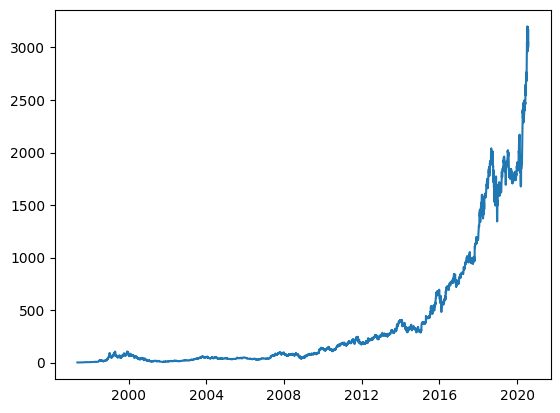

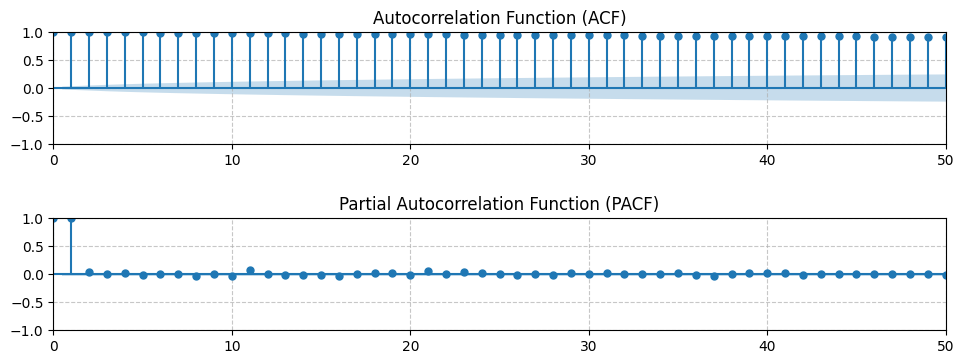




Augmented Dickey-Fuller Test Results: log_Close
ADF Statistic: -1.50
p-value: 0.53
Critical Value (1%): -3.43
Critical Value (5%): -2.86
Critical Value (10%): -2.57
Conclusion: The series is non-stationary (fail to reject H0)


Autocorrelation and Partial Autocorrelation Plots: log_Close


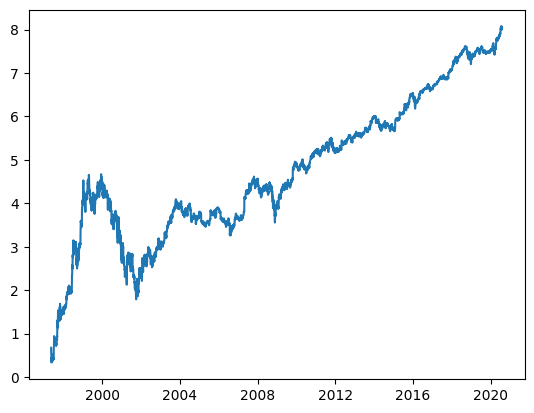

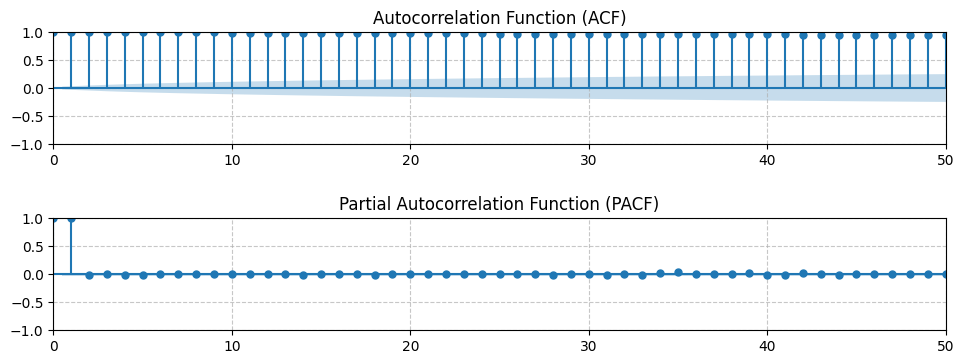




Augmented Dickey-Fuller Test Results: 1st_diff_Close
ADF Statistic: -11.87
p-value: 0.00
Critical Value (1%): -3.43
Critical Value (5%): -2.86
Critical Value (10%): -2.57
Conclusion: The series is stationary (reject H0)
Autocorrelation and Partial Autocorrelation Plots: 1st_diff_Close


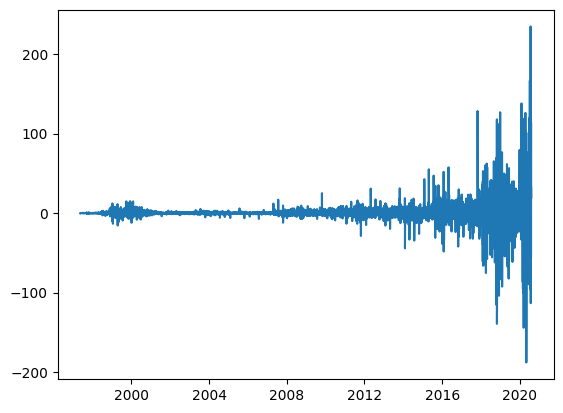

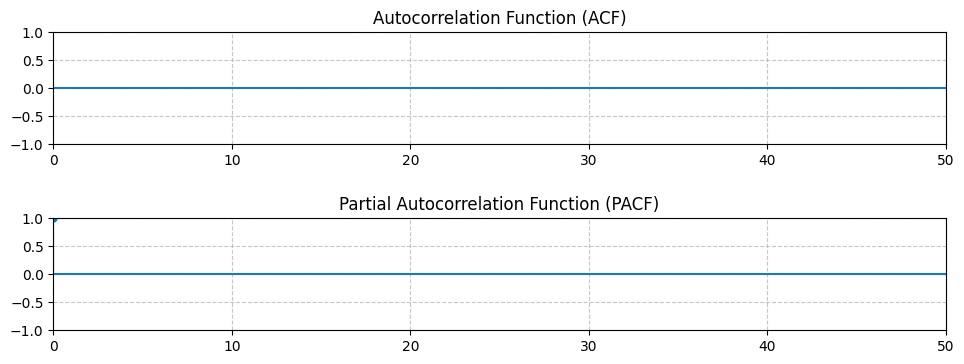




Augmented Dickey-Fuller Test Results: 1st_diff_log_Close
ADF Statistic: -13.02
p-value: 0.00
Critical Value (1%): -3.43
Critical Value (5%): -2.86
Critical Value (10%): -2.57
Conclusion: The series is stationary (reject H0)
Autocorrelation and Partial Autocorrelation Plots: 1st_diff_log_Close


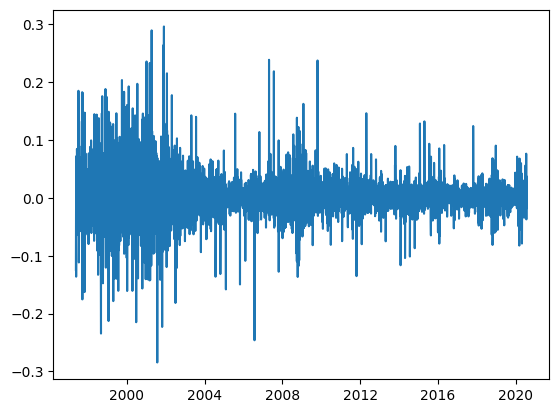

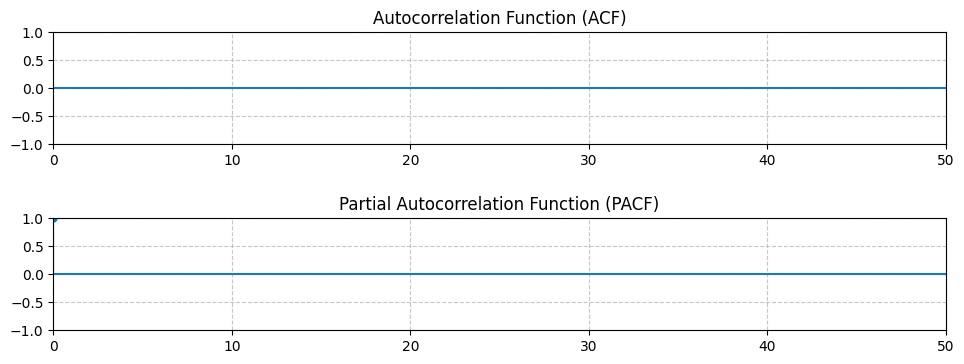

In [101]:
# ADF test for all relevant columns
col = ['Close', 'log_Close', '1st_diff_Close', '1st_diff_log_Close']

for c in col:
    plt.plot(df[c])
    adf_test(df[c])

### Augmented Dickey–Fuller (ADF) Test Summary

| Transformation         | ADF Statistic | p-value | Critical Value (1%) | Critical Value (5%) | Critical Value (10%) | Conclusion |
|------------------------|---------------|----------|---------------------|---------------------|----------------------|-------------|
| **Close**              | 5.62          | 1.00     | -3.43               | -2.86               | -2.57                | ❌ Non-stationary (fail to reject H₀) |
| **log_Close**          | -1.50         | 0.53     | -3.43               | -2.86               | -2.57                | ❌ Non-stationary (fail to reject H₀) |
| **1st_diff_Close**     | -11.87        | 0.00     | -3.43               | -2.86               | -2.57                | ✅ Stationary (reject H₀) |
| **1st_diff_log_Close** | -13.02        | 0.00     | -3.43               | -2.86               | -2.57                | ✅ Stationary (reject H₀) |


**Interpretation**

- Both the **raw** and **log- transformed** closing prices are **non-stationary**

- After **first differencing**, both the raw and log-differenced series become *stationary* (ADF statistic < critical value and p-value ≈ 0). 

- This confirms that the series is **integrated of order 1 (I(1))**, making it suitable for **ARIMA(p,1,q)** or **SARIMA(p,1,q)(P,0,Q,s)**

- The first differencing of the log transfomation is opted to perform an time series analysis.

---

## 4. Modeling Fitting and Residual Diagnostics

### Split Train and Test data

To evaluate the forecasting performance of the model, the data set is divided into training and testing data. \
The last 12 observations are reserved for testing, while the running data are used for model training.

In [102]:
# Split the data into training and testing sets
nobs = 30 # periods for prediction is 1 month
train = df[:-nobs]
test = df[-nobs:]

### Model Fitting

This section focuses on building and optimizing ARIMA models to forecast the closing price. The process is divided into two parts:

###  4.1 ARIMA model

- **Part1**: Run with ARIMA (1,0,1) as a baseline model. It serves as a starting point to evaluate whether a simple ARIMA structure can adequately capture the time-series pattern.

- **Part2** : After the baseline, a systematic loop is applied to explore multiple combinations of ARIMA parametes. Each candiate model is evaluated using AIC,BIC and Ljung-Box test to find the optimal models

### 1. BASELINE ARIMA(1,0,1)

In [103]:
# Fit ARIMA model (1,1,1)
train1 = train[['1st_diff_log_Close']]
arima_model = ARIMA(train1, order=(1,0,1))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:     1st_diff_log_Close   No. Observations:                 5812
Model:                 ARIMA(1, 0, 1)   Log Likelihood               10955.650
Date:                Fri, 07 Nov 2025   AIC                         -21903.300
Time:                        11:12:19   BIC                         -21876.629
Sample:                             0   HQIC                        -21894.023
                               - 5812                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.514      0.012       0.000       0.002
ar.L1         -0.6866      0.190     -3.607      0.000      -1.060      -0.313
ma.L1          0.7030      0.187      3.769      0.0

**Model Interpretation**\

- Both AR(1) and MA(1) terms are highly significant (p < 0.001), confirming short-term dependencies where shocks are partially offset over time.

- The **Ljung–Box test (p = 0.43)** suggests uncorrelated residuals, confirming adequate model specification.

- However, **non-normal residuals (JB p ≈ 0.00)** and **heteroskedasticity (p ≈ 0.00)** indicate volatility clustering.

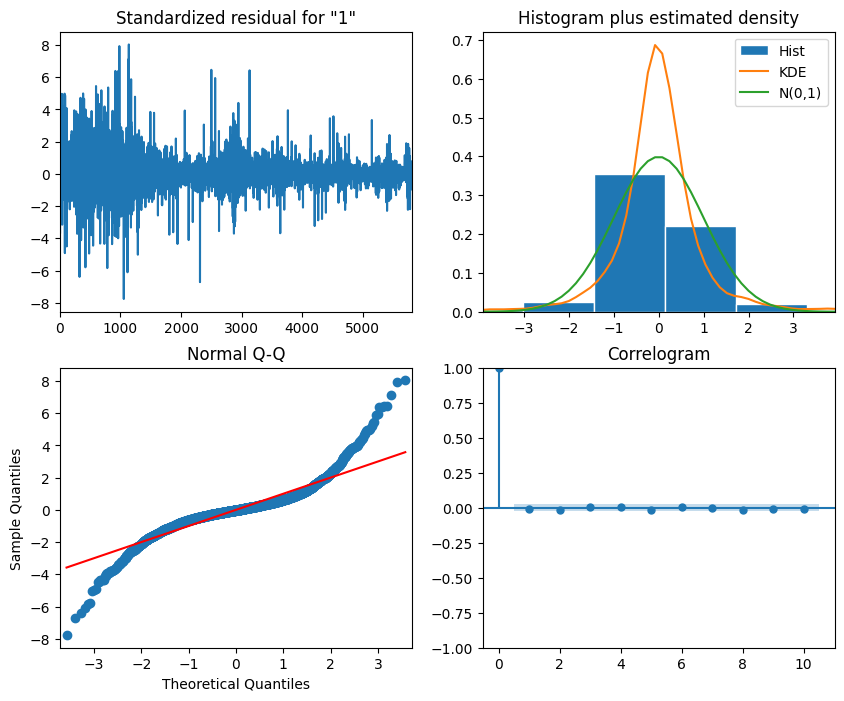

In [104]:
arima_result.plot_diagnostics(figsize=(10,8))
plt.show()

1. **Standardized Residuals**
- The residuals fluctuate around zero, showing no obvious trend and pattern.
- The volatility increases toward the end,suggesting **heteroskedasticity**

2. **Histogram**
- The plot is centered around zero, indicating that residuals have mean of zero.
- The KDE deviate from the normal curve, suggesting the non perfectly normal distribution.

3. **Normal Q-Q plot**
- Most points follow the red diagonal line in the middle but deviate significantly at both tail., meaning that extreame value occurs often than normal distribution would predict.

4. **Correlogram**

- The ACF does not show any spike out of the confidence band.

Overall, higher Order ARIMA or GARCH model is prefered to capture more complex trends and volatility clustering observed in data.

---

### 2. Grid Seacrh For ARIMA model

In this section, the optimal ARIMA model parameters are determined by using a loop to find the top model for the prediction.

In [105]:
# Fix randomness
np.random.seed(42)

# Define the p, d, q parameters to take any value between 0 and 5
p = range(0,6)
d = range(0,2)
q = range(0,6)
pdq = list(itertools.product(p,d,q))

results = []
# Loop through all combinations
for (p,d,q) in pdq:
    try:
        model = ARIMA(train['1st_diff_log_Close'],
                       order=(p,d,q),enforce_invertibility= True,
                       enforce_stationarity= True,trend= 'c')
        fit = model.fit()

        # Ljung Box test 
        resid = fit.resid.dropna()
        lb_test = acorr_ljungbox(resid, lags=[10], return_df=True)
        lb_p = lb_test['lb_pvalue'].iloc[0]

        results.append({
            "Model": f"ARIMA({p},{d},{q})",
            "AIC": round(fit.aic, 3),
            "BIC": round(fit.bic, 3),
            "Ljung-Box p-value": round(lb_p, 3)
        })
    except Exception as e:
        print(f"Skipped ARIMA({p},{d},{q}): {e}")

if results:
    results_df = pd.DataFrame(results).sort_values(by=["AIC"]).drop_duplicates(subset=["Model"]).reset_index(drop=True)
    print(results_df.head(10))
else:
    print("No valid ARIMA models were fitted.")

Skipped ARIMA(0,1,0): In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.
Skipped ARIMA(0,1,1): In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing operation). For example, a constant cannot be included in an ARIMA(1, 1, 1) model, but including a linear trend, which would have the same effect as fitting a constant to the differenced data, is allowed.
Skipped ARIMA(0,1,2): In models with integration (`d > 0`) or seasonal integration (`D > 0`), trend terms of lower order than `d + D` cannot be (as they would be eliminated due to the differencing

### Interpretation
- The lowest AIC value is achieved by ARIMA(2,0,0), followed by ARIMA (2,0,0) and (3,0,0)
- All model show p-values > 0.05, confirming that residuals are independent.
- Overall, both the top 5 model are the canidates for the prediction, compared with test set.

---


### Plot All Top Best 5 Models

This section visualizes the forecast performance of the top five model, selected base on their base evaluation metrics, Each subplot compares the model's predicted closing price against the actual test values. The root mean squared for each model is displayed in the table and title to provide a quick reference of predicion preformance

In [106]:
# Define the models to be evaluated
model_1 = ARIMA(train['1st_diff_log_Close'], order=(0,0,2))
model_2 = ARIMA(train['1st_diff_log_Close'], order=(2,0,0))
model_3 = ARIMA(train['1st_diff_log_Close'], order=(3,0,0))
model_4 = ARIMA(train['1st_diff_log_Close'], order=(0,0,3))
model_5 = ARIMA(train['1st_diff_log_Close'], order=(1,0,2))


# Fit the models
result_1 = model_1.fit()
result_2 = model_2.fit()
result_3 = model_3.fit()
result_4 = model_4.fit()
result_5 = model_5.fit()

# Predict on the test set
start = len(train)
end = len(train) + len(test) - 1

pred1 = result_1.predict(start=start, end=end, typ='levels')
pred2 = result_2.predict(start=start, end=end, typ='levels')
pred3 = result_3.predict(start=start, end=end, typ='levels')
pred4 = result_4.predict(start=start, end=end, typ='levels')
pred5 = result_5.predict(start=start, end=end, typ='levels')

last_log_value = train['log_Close'].iloc[-1]
# Inverse transformation to get actual price predictions
pred_log_1 = last_log_value + pred1.cumsum()
pred_log_2 = last_log_value + pred2.cumsum()
pred_log_3 = last_log_value + pred3.cumsum()
pred_log_4 = last_log_value + pred4.cumsum()
pred_log_5 = last_log_value + pred5.cumsum()

pred_price_1 = np.exp(pred_log_1)
pred_price_2 = np.exp(pred_log_2)
pred_price_3 = np.exp(pred_log_3)
pred_price_4 = np.exp(pred_log_4)
pred_price_5 = np.exp(pred_log_5)

# Evaluate model performance
orders =  [(0,0,2), (2,0,0), (3,0,0), (0,0,3), (1,0,2)]
results = []

for (p, d, q), pred in zip(orders, [pred_price_1, 
                                    pred_price_2, pred_price_3, 
                                    pred_price_4, pred_price_5]):
    rmse = root_mean_squared_error(test['Close'], pred)
    mae = mean_absolute_error(test['Close'], pred)
    results.append({
        "Model": f"ARIMA({p},{d},{q})",
        "RMSE": round(rmse, 3),
        "MAE": round(mae, 3)
    })

results_df = pd.DataFrame(results).sort_values(by=["RMSE"]).reset_index(drop=True)

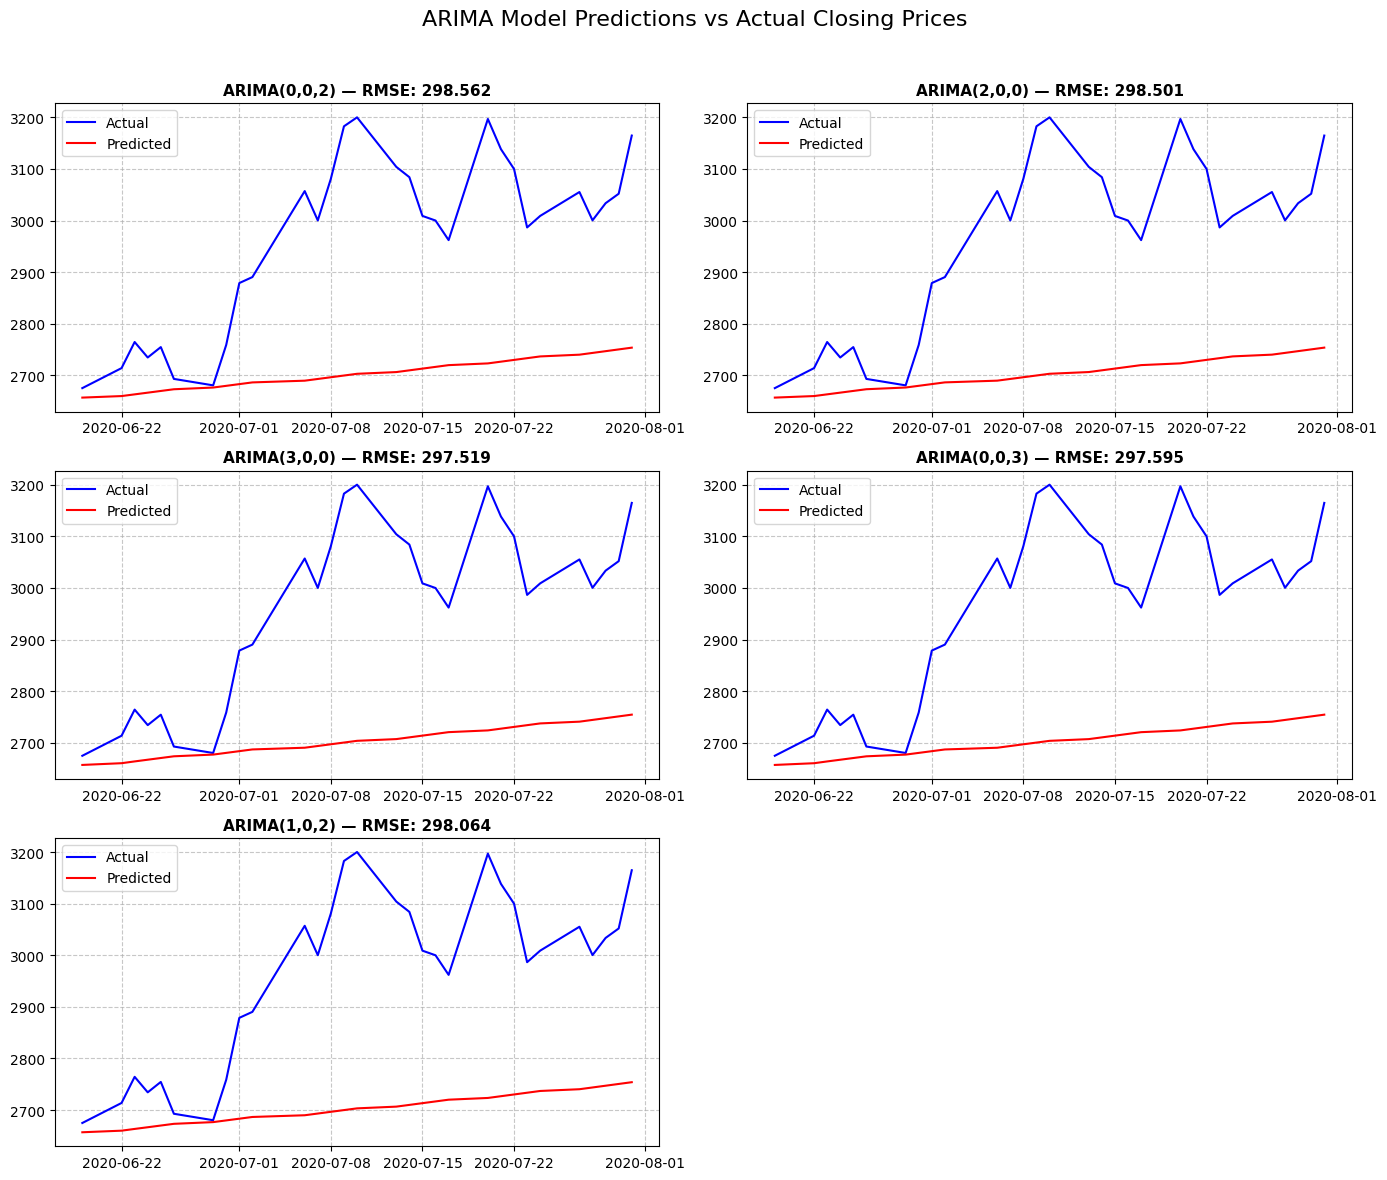

          Model    RMSE     MAE
0  ARIMA(3,0,0) 297.519 259.514
1  ARIMA(0,0,3) 297.595 259.598
2  ARIMA(1,0,2) 298.064 260.122
3  ARIMA(2,0,0) 298.501 260.617
4  ARIMA(0,0,2) 298.562 260.684


mean of test set: 2965.302


In [107]:
# plot all predictions vs actuals

# Prepare predictions and model names for plotting
preds = [
    (pred_price_1, 'ARIMA(0,0,2)', 
     results_df.loc[results_df['Model'].str.contains('0,0,2'), 'RMSE'].values[0]),
    (pred_price_2, 'ARIMA(2,0,0)',
      results_df.loc[results_df['Model'].str.contains('2,0,0'), 'RMSE'].values[0]),
    (pred_price_3, 'ARIMA(3,0,0)', 
     results_df.loc[results_df['Model'].str.contains('3,0,0'), 'RMSE'].values[0]),
    (pred_price_4, 'ARIMA(0,0,3)', 
     results_df.loc[results_df['Model'].str.contains('0,0,3'), 'RMSE'].values[0]),
    (pred_price_5, 'ARIMA(1,0,2)', 
     results_df.loc[results_df['Model'].str.contains('1,0,2'), 'RMSE'].values[0])
]

# Determine subplot grid size
n_models = len(preds)
ncols = 2
nrows = math.ceil(n_models/ncols)

fig,axes = plt.subplots(nrows,ncols, figsize=(14, nrows*4))
axes = axes.flatten()

# Plot actual vs predicted for each model
for i,(pred,name,rmse) in enumerate(preds):
    ax = axes[i]
    ax.plot(test.index, test['Close'], label='Actual', color='blue')
    ax.plot(test.index,pred, label='Predicted', color='red')
    ax.set_title(f'{name} — RMSE: {rmse:.3f}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('ARIMA Model Predictions vs Actual Closing Prices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print(results_df)
print("\n")
print(f"mean of test set: {test['Close'].mean():.3f}")

### **Model Evaluation Summary**

The figures above depict the forecast performance of the top 5 models,selected base on AIC lowest value. Each plot compares **actual prices**(blue) against **forcast price**(orange)

#### **Interpretation**
- The average test set value is around 2965.3, while all model RMSE values are around 297–299, indicating that each model’s forecast errors are roughly 10% of the mean level, which suggests moderate accuracy.
- The best-performing models are **ARIMA(3,0,0) (RMSE = 297.52)** and **ARIMA(0,0,3) (RMSE = 297.60)**, showing nearly identical results.

- However, the **predicted series (red line)** appears overly flat and smoothed compared to the **actual prices (blue line)**. This suggests that the models are not capturing the underlying trend or short-term fluctuations in the data effectively.

---

### 2. SARIMA Model

The Seasonal ARIMA (SARIMA) model is an extension of the ARIMA framework that accounts for both trend and seasonality in time-series data.

- Part 1: Baseline SARIMA model: A baseline SARIMA configuration is first developed using prior knowledge of the data’s seasonal structure. This initial model provides a benchmark for evaluating the influence of seasonal components and for diagnosing residual behavior before systematic tuning.

- Part 2: Grid search procedure is implemented to automatically test multiple combinations of seasonal and non-seasonal parameters. Each candidate model is evaluated based on AIC, BIC, and Ljung–Box statistics to identify the optimal balance between model fit and parsimony.

### 1. Baseline SARIMA Model:

In [108]:
sarima_model = SARIMAX(train['1st_diff_log_Close'].dropna(), 
                        order=(1,0,1),
                        seasonal_order=(1,0,1,5),
                        enforce_invertibility=True,
                        enforce_stationarity=True,
                        trend='c')

sarima_result = sarima_model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                1st_diff_log_Close   No. Observations:                 5811
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 5)   Log Likelihood               10956.236
Date:                           Fri, 07 Nov 2025   AIC                         -21900.472
Time:                                   11:13:14   BIC                         -21860.467
Sample:                                        0   HQIC                        -21886.557
                                          - 5811                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.002      1.425      0.154      -0.001       0.005
ar.L1         -0.7517      0.160     -4.712

### Interpretation
- **AR(1)** and **MA(1)** are significant at 95% confidence level while, the seasonal components are insignifcant, suggesting no clear seasonality and capture short term trend.

- Residuals show no autocorrlation with p-value of 0.43

- SARIMA baseline model **yields similar result** like ARIMA baseline model

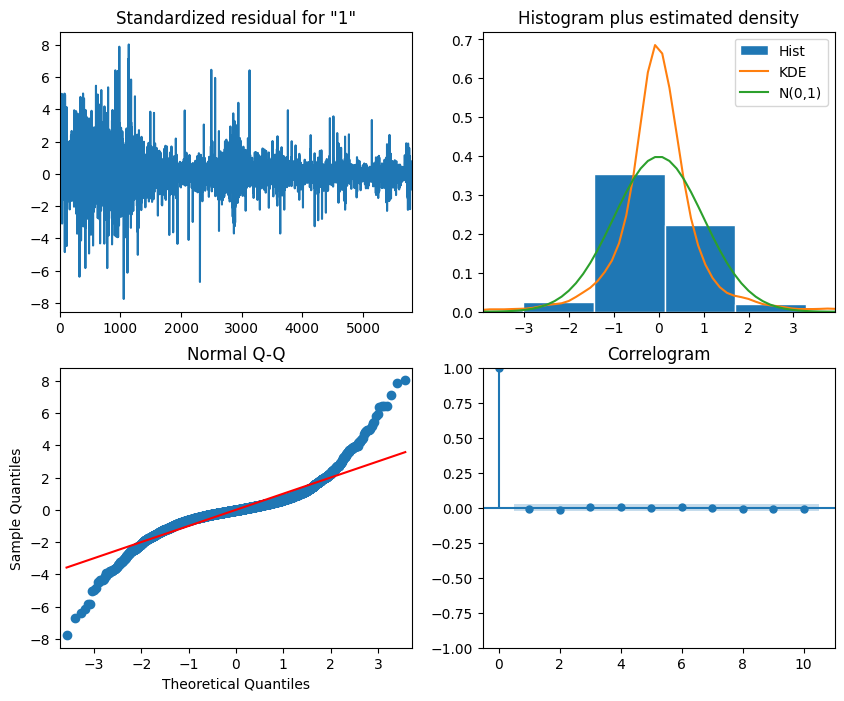

In [109]:
sarima_result.plot_diagnostics(figsize=(10,8))
plt.show()

. **Standardized Residuals**
- The residuals fluctuate randomly around zero with no clear pattern
- The volatility increases in the beginning and middle, suggesting **heteroskedasticity**

2. **Histogram**

- The blue bars and orange KDE curve deviate from the green normal curve, suggesting non-normal residuals with heavier tails.

3. **Normal Q-Q plot**
- Points deviate from the red diagonal line, especially at both ends, confirming heavy-tailed distribution.

4. **Correlogram**

- No significant spike after lag 0, meaning the residuals are uncorrelated.

---

### 2. Grid Seacrh For SARIMA model

In [110]:
# Fix randomness
np.random.seed(42)

# Define the p, d, q parameters to take any value between 0 and 5
# Define the P, D, Q parameters to take any value between 0 and 2 or 3
p = range(0,3)
d = [0]
q = range(0,3)
P = range(0,3)
D = range(0,2)
Q = range(0,3)
s = [5] # seasonal period ,5 working days for stock market

pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q,s))

results = []

# Loop through all combinations
for (p,d,q) in pdq:
    for (P,D,Q,s) in seasonal_pdq:
        try:
            model = SARIMAX(train['1st_diff_log_Close'],
                           order=(p,d,q),
                           seasonal_order=(P,D,Q,s),
                           enforce_invertibility= True,
                           enforce_stationarity= True,
                           trend= 'c',stepwise = True)
            fit = model.fit()

            # Ljung Box test 
            resid = fit.resid.dropna()
            lb_test = acorr_ljungbox(resid, lags=[10], return_df=True)
            lb_p = lb_test['lb_pvalue'].iloc[0]

            results.append({
                "Model": f"SARIMA({p},{d},{q})x({P},{D},{Q},{s})",
                "AIC": round(fit.aic, 3),
                "BIC": round(fit.bic, 3),
                "Ljung-Box p-value": round(lb_p, 3)
            })
        except Exception as e:
            print(f"Skipped SARIMA({p},{d},{q})x({P},{D},{Q},{s}): {e}")

if results:
    results_df = (pd.DataFrame(results).sort_values(by=["AIC"]).drop_duplicates(subset=["Model"]).reset_index(drop=True))
    print(results_df.head(10))
else:
    print("No valid SARIMA models were fitted.")


                     Model        AIC        BIC  Ljung-Box p-value
0  SARIMA(0,0,2)x(0,0,0,5) -21905.674 -21879.003              0.907
1  SARIMA(2,0,0)x(0,0,0,5) -21905.629 -21878.958              0.904
2  SARIMA(1,0,2)x(0,0,0,5) -21904.522 -21871.184              0.954
3  SARIMA(0,0,0)x(0,0,0,5) -21904.318 -21890.983              0.435
4  SARIMA(0,0,2)x(1,0,0,5) -21904.292 -21870.953              0.941
5  SARIMA(0,0,2)x(0,0,1,5) -21904.287 -21870.949              0.941
6  SARIMA(2,0,0)x(1,0,0,5) -21904.246 -21870.908              0.939
7  SARIMA(2,0,0)x(0,0,1,5) -21904.242 -21870.903              0.939
8  SARIMA(2,0,1)x(0,0,0,5) -21903.934 -21870.595              0.928
9  SARIMA(2,0,2)x(0,0,0,5) -21903.740 -21863.734              0.988


### Model Selection Summary
- A total of multiple SARIMA configurations were evaluated based on AIC, BIC and Ljung-Box test to identify the most suitable model for the `1st_diff_log_Close`

- The top five model achieves the values AIC between -21905 and -21904, indicating very similar fit with only marginal differencs across configurations.

- The models with AR term and MA term are selected to perform the forecasting.

- Selected model:
    - 1. SARIMA (0,0,2) (0,0,0,5)
    - 2. SARIMA (2,0,0) (0,0,0,5)
    - 3. SARIMA (1,0,2) (0,0,0,5)
    - 4. SARIMA (0,0,2) (1,0,0,5)
    - 5. SARIMA (0,0,2) (0,0,1,5)


In [111]:
model_1 = SARIMAX(train['1st_diff_log_Close'], 
                 order=(0,0,2),
                 seasonal_order=(0,0,0,5),
                 enforce_invertibility=True,
                 enforce_stationarity=True,
                 trend='c')

model_2 = SARIMAX(train['1st_diff_log_Close'], 
                 order=(2,0,0),
                 seasonal_order=(0,0,0,5),
                 enforce_invertibility=True,
                 enforce_stationarity=True,
                 trend='c')

model_3 = SARIMAX(train['1st_diff_log_Close'], 
                 order=(1,0,2),
                 seasonal_order=(0,0,0,5),
                 enforce_invertibility=True,
                 enforce_stationarity=True,
                 trend='c')

model_4 = SARIMAX(train['1st_diff_log_Close'], 
                 order=(0,0,2),
                 seasonal_order=(1,0,0,5),
                 enforce_invertibility=True,
                 enforce_stationarity=True,
                 trend='c')
model_5 = SARIMAX(train['1st_diff_log_Close'], 
                 order=(0,0,2),
                 seasonal_order=(0,0,1,5),
                 enforce_invertibility=True,
                 enforce_stationarity=True,
                 trend='c')

model_1_result = model_1.fit()
model_2_result = model_2.fit()
model_3_result = model_3.fit()
model_4_result = model_4.fit()
model_5_result = model_5.fit()

# Predict on the test set
start = len(train)
end = len(train) + len(test) - 1

# Predictions of all models
pred1 = model_1_result.predict(start=start, end=end, typ='levels')
pred2 = model_2_result.predict(start=start, end=end, typ='levels')
pred3 = model_3_result.predict(start=start, end=end, typ='levels')
pred4 = model_4_result.predict(start=start, end=end, typ='levels')
pred5 = model_5_result.predict(start=start, end=end, typ='levels')

# Inverse transformation to get actual price predictions
last_log_value = train['log_Close'].iloc[-1]

pred_log_1 = last_log_value + pred1.cumsum()
pred_log_2 = last_log_value + pred2.cumsum()
pred_log_3 = last_log_value + pred3.cumsum()
pred_log_4 = last_log_value + pred4.cumsum()
pred_log_5 = last_log_value + pred5.cumsum()

pred_price_1 = np.exp(pred_log_1)
pred_price_2 = np.exp(pred_log_2)
pred_price_3 = np.exp(pred_log_3)
pred_price_4 = np.exp(pred_log_4)
pred_price_5 = np.exp(pred_log_5)


SARIMA Model Evaluation Results:
                     Model    RMSE     MAE
0  SARIMA(1,0,2)x(0,0,0,5) 298.149 260.198
1  SARIMA(0,0,2)x(0,0,0,5) 298.364 260.495
2  SARIMA(2,0,0)x(0,0,0,5) 298.375 260.497
3  SARIMA(0,0,2)x(0,0,1,5) 298.981 261.148
4  SARIMA(0,0,2)x(1,0,0,5) 299.012 261.183


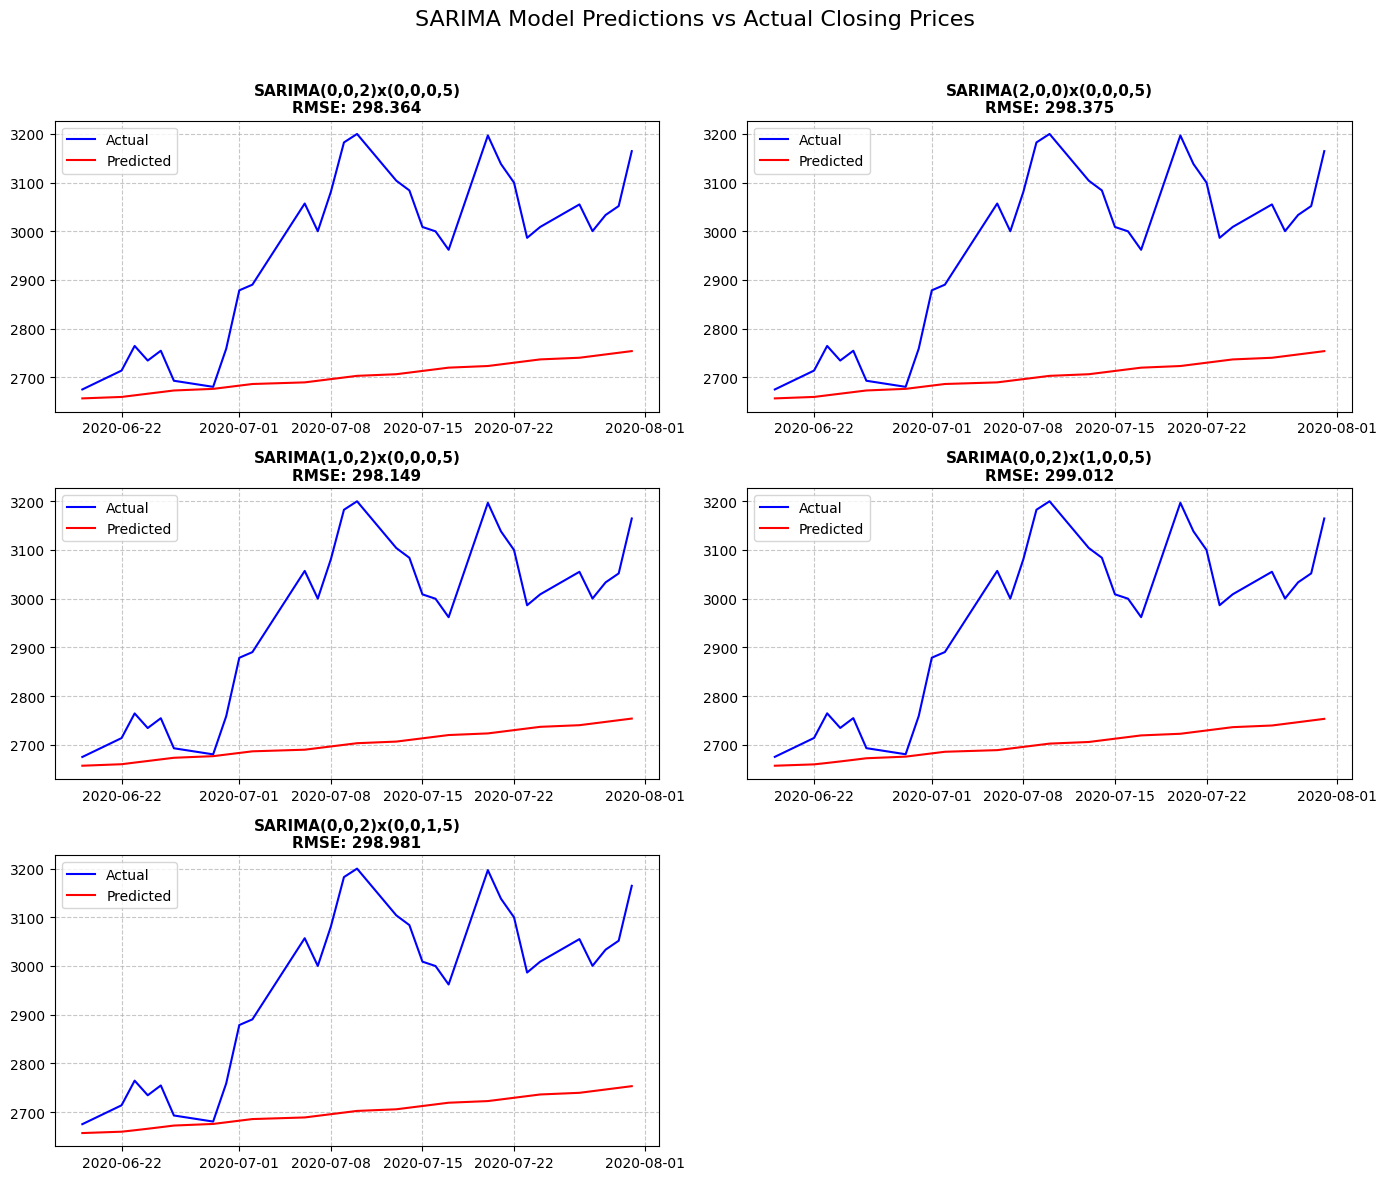


Mean of test set: 2965.302


In [112]:
# Prepare predictions, exact model names
model_names = [
    'SARIMA(0,0,2)x(0,0,0,5)',
    'SARIMA(2,0,0)x(0,0,0,5)',
    'SARIMA(1,0,2)x(0,0,0,5)',
    'SARIMA(0,0,2)x(1,0,0,5)',
    'SARIMA(0,0,2)x(0,0,1,5)'
]

preds_all = [pred_price_1, pred_price_2, pred_price_3, pred_price_4, pred_price_5]
metrics = []
for name, pred in zip(model_names, preds_all):
    rmse = root_mean_squared_error(test['Close'], pred)
    mae = mean_absolute_error(test['Close'], pred)
    metrics.append({'Model': name, 'RMSE': rmse, 'MAE': mae})

results_df = pd.DataFrame(metrics).sort_values(by='RMSE').reset_index(drop=True)
print("\nSARIMA Model Evaluation Results:")
print(results_df)

# --- Step 2: Combine predictions and RMSE for plotting
preds = []
for pred, name in zip(preds_all, model_names):
    rmse_val = results_df.loc[results_df['Model'] == name, 'RMSE']
    rmse = rmse_val.values[0] if not rmse_val.empty else np.nan
    preds.append((pred, name, rmse))

# --- Step 3: Plot Actual vs Predicted
n_models = len(preds)
ncols = 2
nrows = math.ceil(n_models / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 4))
axes = axes.flatten()

for i, (pred, name, rmse) in enumerate(preds):
    ax = axes[i]
    ax.plot(test.index, test['Close'], label='Actual', color='blue')
    ax.plot(test.index, pred, label='Predicted', color='red')
    ax.set_title(f'{name}\nRMSE: {rmse:.3f}', fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('SARIMA Model Predictions vs Actual Closing Prices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Step 4: Display summary
print("\nMean of test set:", round(test['Close'].mean(), 3))


### Interpretation of SARIMA Forecast Comparision

- All five model produce similar forecasting pattern, with predicted lines overlapping. RMSE values are all close ($\approx 298 - 299$)

- All models fail to capture the strong short term fluctuations in the actual data.

- SARIMA models yield the similar result with ARIMA model.

Overall, SARIMA models perfrom consistenly perform consistently, with all achieving similar RMSE values around 298.
However, their forecasts are overly smooth and underreact to rapid changes in closing prices.
This suggests that while the models capture the mean trend effectively, short-term volatility or shocks remain unexplained. The GARCH moodel is prefered for the further investigation.

---

### 3. GARCH

The Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model is used to analyze and forecast financial market volatility. It captures time-varying variance. GARCH is widely applied in finance to model risk, returns, and market uncertainty.

In this section, log returns are computed to facilitate the volatility analysis. The dataset is divided into 80% for training and 20% for testing to evaluate model performance effectively.

- Part1 : The GARCH(1,1) model is implemented as the baseline to capture time-varying volatility in the stock returns.

- Part2 : A grid search approach is applied to identify the optimal model parameters and improve forecasting accuracy.

In [113]:
# Create log returns column
df['log_returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
returns = 100* df['log_returns'].dropna()

<Axes: xlabel='Date'>

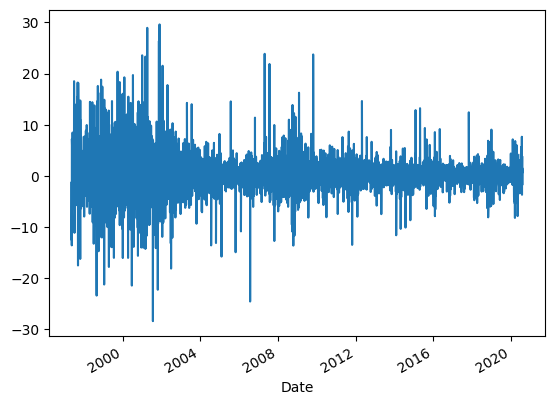

In [114]:
# plot log returns
returns.plot()




Augmented Dickey-Fuller Test Results: log_returns
ADF Statistic: -13.02
p-value: 0.00
Critical Value (1%): -3.43
Critical Value (5%): -2.86
Critical Value (10%): -2.57
Conclusion: The series is stationary (reject H0)
Autocorrelation and Partial Autocorrelation Plots: log_returns


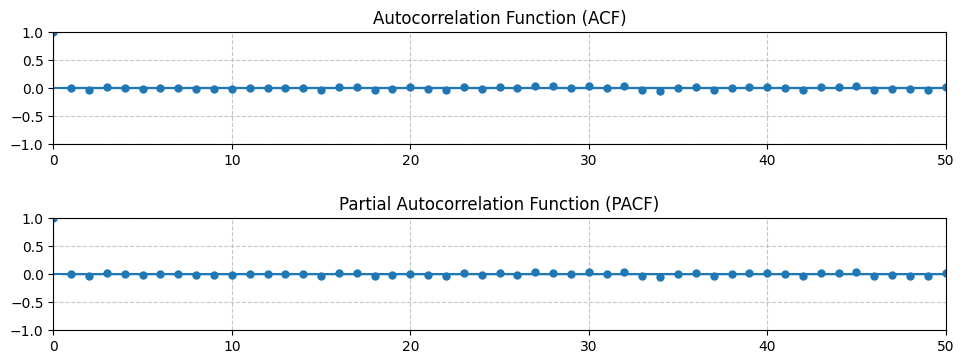

In [115]:
# Perform ADF test on log returns
adf_test(returns)

### Interpreatation

- The ACF and PACF plots of the log return series show no significant autocorrelation at any lag.

- The mean process of the returns does not exhibit any predictable pattern or trend. Thus, `mean = constant` specification is suffecient in the GARCH model.

### Volatility Clustering and ARCH Effect Tests

ARCH LM stat: 437.166, p-value: 0.000


Ljung–Box on squared returns (lag 10) p-value: 0.0000


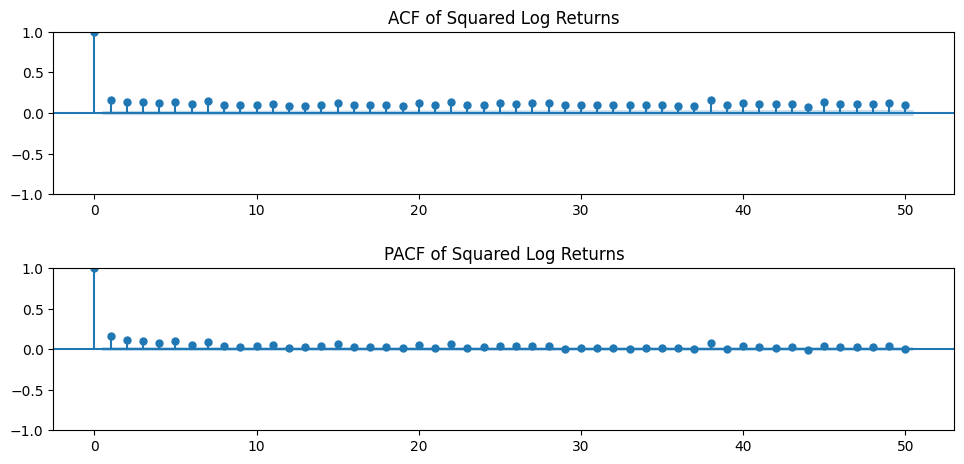

In [116]:
# Lagrage Multiplier test
arch_stat, arch_p,_,_ = het_arch(returns)
print(f"ARCH LM stat: {arch_stat:.3f}, p-value: {arch_p:.3f}")
print("\n")

# Ljung-Box test on squared returns
lb_sq = acorr_ljungbox(returns**2, lags=[10], return_df=True)
print(f"Ljung–Box on squared returns (lag 10) p-value: {lb_sq['lb_pvalue'].iloc[0]:.4f}")


# ACF plot for squared log returns
fig, ax = plt.subplots(2,1,figsize=(10,5))
plot_acf(returns**2, lags=50,ax=ax[0])
ax[0].set_title('ACF of Squared Log Returns')
plot_pacf(returns**2, lags=50,ax=ax[1])
ax[1].set_title('PACF of Squared Log Returns')
plt.tight_layout(pad=2.0)
plt.show()

### Interpretation 

- The Engle's ARCH LM test null hypothesis of homoskedasticity is rejected at 95% confidence level.

- The Ljung-Box test null hypotheis of no autocorrelation is rejected. Thus, there is an evidence that the volatility clustering.

- The ACF and PACF plots of squared log returns show significant positive autocorrelation at multiple lags.

- This indicates that large movements in returns tend to cluster together.


### Split Train and Test Data.

In [117]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train_returns = returns[:train_size]
test_returns = returns[train_size:]

The data is splited in to 80 percent of training set and the remaining 20 percent of the testing set.

### 1. Baseline model of GARCH (1,1)

In [118]:
# Fit GARCH(1,1) model
garch11 = arch_model(train_returns, vol='GARCH', p=1, q=1)
result = garch11.fit(disp = 'off')
print(result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:            log_returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12244.2
Distribution:                  Normal   AIC:                           24496.3
Method:            Maximum Likelihood   BIC:                           24522.1
                                        No. Observations:                 4673
Date:                Fri, Nov 07 2025   Df Residuals:                     4672
Time:                        11:31:30   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1155  3.957e-02      2.919  3.507e-03 [3.796e-0

### Interpretation

- All estimated parameters are statistically sinificant at 95 % confidence level.
- The $\alpha_1$ (0.1) and $\beta_1$ (0.88) coefficients indicates taht volatility is highly persistence ($\alpha_1 +\beta_1 \approx 1$)
- The positive $\omega$ cofimrs a stable long-run variance level and the Student-t parameter (ν $\approx$ 3.8) shows heavy-tailed residuals.  

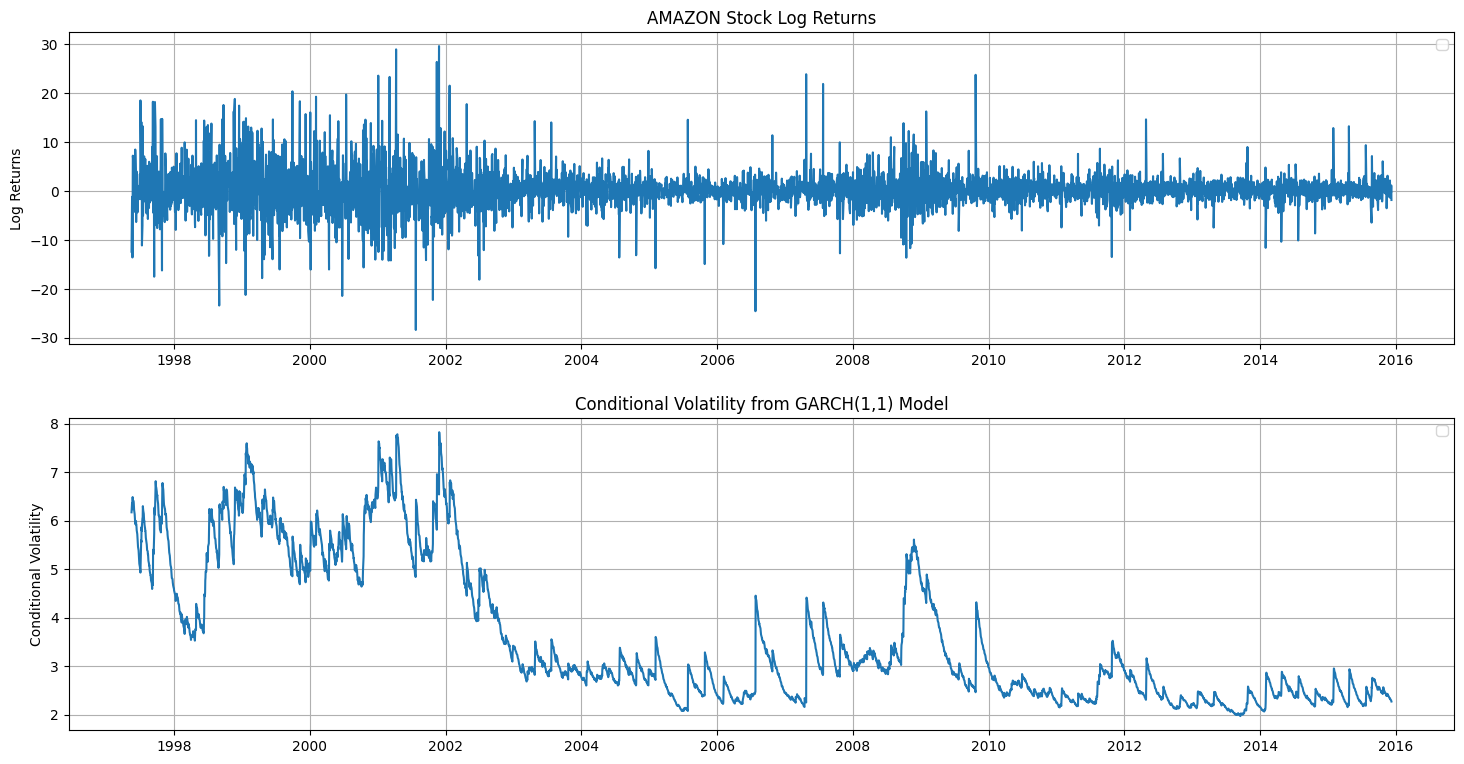

In [119]:
plt.figure(figsize = (15,8))
plt.subplot(2,1,1)
plt.plot(train_returns)
plt.ylabel('Log Returns')
plt.title('AMAZON Stock Log Returns')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.plot(result.conditional_volatility)
plt.ylabel('Conditional Volatility')
plt.title('Conditional Volatility from GARCH(1,1) Model')
plt.grid()
plt.legend()


plt.tight_layout(pad=2.0)
plt.show()

The GARCH (1,1) model effectively captures the time varying volatility. Volatility is clustered, persistent, and mean-reverting, increasing during the during crisis periods and gradually stabilizing afterward.

In [120]:
reside = result.resid
std_resid = result.std_resid

print("Ljung–Box p (resid):", acorr_ljungbox(std_resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0])
print("Ljung–Box p (resid²):", acorr_ljungbox(std_resid**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0])

Ljung–Box p (resid): 0.5757342965121109
Ljung–Box p (resid²): 0.9480216540538574


### Interpretation of GARCH(1,1) Results

- **Standardized Residuals**: The residuals fluctuate randomly around zero without visible patterns, meaning the mean equation is well specified.

- **Conditional Volatility**: The plot shows time varying variance  and high volatility in the early years that gradually declines over time.

- **Ljung-Box p(resid) = 0.77**: The residuals show no significant autocorrelation

- **Ljung-Box p(resid²) = 0.98**: The squared residuals also have no significant autocorrelation, indicating ARCH effects are no longer present.

### Stability Condition

In [121]:
alpha = result.params['alpha[1]']
beta = result.params['beta[1]']

print(f"Alpha + Beta = {alpha + beta:.4f}")

if alpha + beta < 1:
    print("Model is stable (stationary).")
else:
    print("Model may be unstable (non-stationary).")

Alpha + Beta = 0.9929
Model is stable (stationary).


### Forecasted Conditional Volatility vs Realized Returns

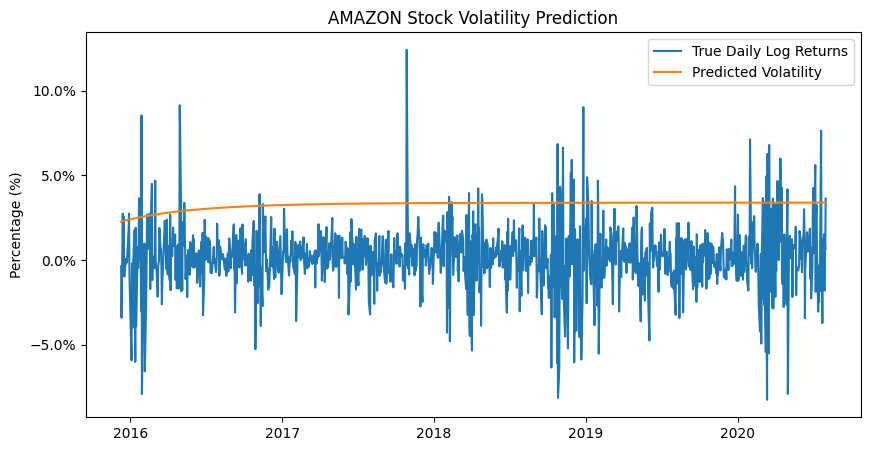

In [122]:
# Forecast the conditional volatility
forecast = result.forecast(horizon = len(test_returns))

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(test_returns)
ax.plot(test_returns.index,np.sqrt(forecast.variance.values[-1,:]))
ax.set_title('AMAZON Stock Volatility Prediction')
ax.legend(['True Daily Log Returns', 'Predicted Volatility'])
ax.set_ylabel('Percentage (%)')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=100))
plt.show()

The plot compares actual daily log returns with the GARCH(1,1) model’s predicted conditional volatility. Volatility forecasts remain elevated during high-risk periods and gradually revert toward a stable long-run level, consistent with volatility clustering. Although individual return spikes occasionally exceed the predicted volatility, the model effectively tracks persistent changes in volatility over time.

### Rolling Multi-Model Volatility Forecast Function

This function performs a rolling one-step-ahead volatility forecast using
multiple ARCH-family models (ARCH, GARCH, EGARCH, etc.) on a given return series.

At each step of the rolling window, the model is re-estimated using all data up to
that point, and the next-day volatility is forecasted.  
The process is repeated for the specified test window length, allowing for a dynamic
comparison of how different volatility models behave over time.

The resulting plots display each model’s forecasted volatility (red) alongside
the actual returns (blue) for visual evaluation of how well each model captures
volatility clustering and persistence.

In [123]:
def rolling_multi_vol_forecast(returns, test_size=365, p=1, q=1, o=0, dist='t', vols=['ARCH','GARCH','EGARCH'], plot=True):
    
    returns = returns.dropna()
    forecasts = {}
    metrics = {}

    # Loop through each volatility model type
    for vol_type in vols:
        rolling_preds = []
        print(f"Running rolling forecast for {vol_type}...")

        for i in range(test_size):
            train = returns[:-(test_size - i)]
            try:
                model = arch_model(train, mean='Constant', vol=vol_type, p=p, q=q, o=o, dist=dist)
                model_fit = model.fit(disp='off')
                forecast = model_fit.forecast(horizon=1, reindex=True)
                rolling_preds.append(np.sqrt(forecast.variance.values[-1, :][0]))
            except Exception as e:
                rolling_preds.append(np.nan)
                print(f"Skipped {vol_type} at step {i}: {e}")

        forecasts[vol_type] = pd.Series(rolling_preds, index=returns[-test_size:].index)

        # Store predictied volatility
        preds = pd.Series(rolling_preds,index = returns[-test_size:].index)
        forecasts[vol_type] = preds

        # Calculate MAE and RMSE
        realized_vol = returns[-test_size:]**2
        mae = mean_absolute_error(np.sqrt(realized_vol), preds)
        rmse = root_mean_squared_error(np.sqrt(realized_vol), preds)
        metrics[vol_type] = {'MAE': mae, 'RMSE': rmse}
    
    metrics_df = pd.DataFrame(metrics).T
    print("\n=== Forecast Error Metrics ===")
    print(metrics_df.round(3))
    print(f"Mean of the test set: {realized_vol.mean():.3f}")
    print("\n")

    # Plot all models
    if plot:
        n_models = len(vols)
        fig, axes = plt.subplots(n_models, 1, figsize=(12, 4*n_models), sharex=True)

        if n_models == 1:
            axes = [axes]  

        for ax, vol_type in zip(axes, vols):
            preds = forecasts[vol_type]
            ax.plot(preds.index,preds, label=f'{vol_type} Forecasted Volatility', color='red')
            ax.plot(returns[-test_size:].index,returns[-test_size:], label='True Returns', color='blue', alpha=0.5)
            ax.set_title(f'{vol_type} Rolling Forecast vs True Returns')
            ax.set_xlabel('Date')
            ax.set_ylabel('Volatility (%)')
            yticks = ax.get_yticks()
            ax.set_yticklabels([f"{y:.1f}%" for y in yticks])
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()
    
    
    return None

**Inputs:**
- `returns` *(pd.Series)*  : Series of log returns (preferably multiplied by 100 for stability).  

- `test_size` *(int, default=365)* : Number of days for the rolling forecast window.  

- `p`, `q` *(int, default=1)* : Orders of the GARCH model (ARCH and GARCH terms).  

- `o` (int,default = 0) : Order of the asymmetry term

- `dist` *(str, default='normal')* : Residual distribution (‘normal’, ‘t’, ‘ged’, etc.).  

- `mean` *(str, default='Constant')* : Mean model type (‘Constant’, ‘Zero’, etc.).  

- `vol` *(str, default='GARCH')* : Volatility model type (‘GARCH’, ‘EGARCH’, ‘GJR-GARCH’).  

- `plot` *(bool, default=True)* : If True, produces a volatility vs. return plot.

**Outputs:**
- Optionally displays a plot comparing forecasted volatility (red) vs. actual returns (blue).
- Table compares RMSE and MAE of each models.

Running rolling forecast for ARCH...
Running rolling forecast for GARCH...
Running rolling forecast for EGARCH...

=== Forecast Error Metrics ===
         MAE  RMSE
ARCH   1.961 2.180
GARCH  1.271 1.527
EGARCH 1.261 1.526
Mean of the test set: 3.679




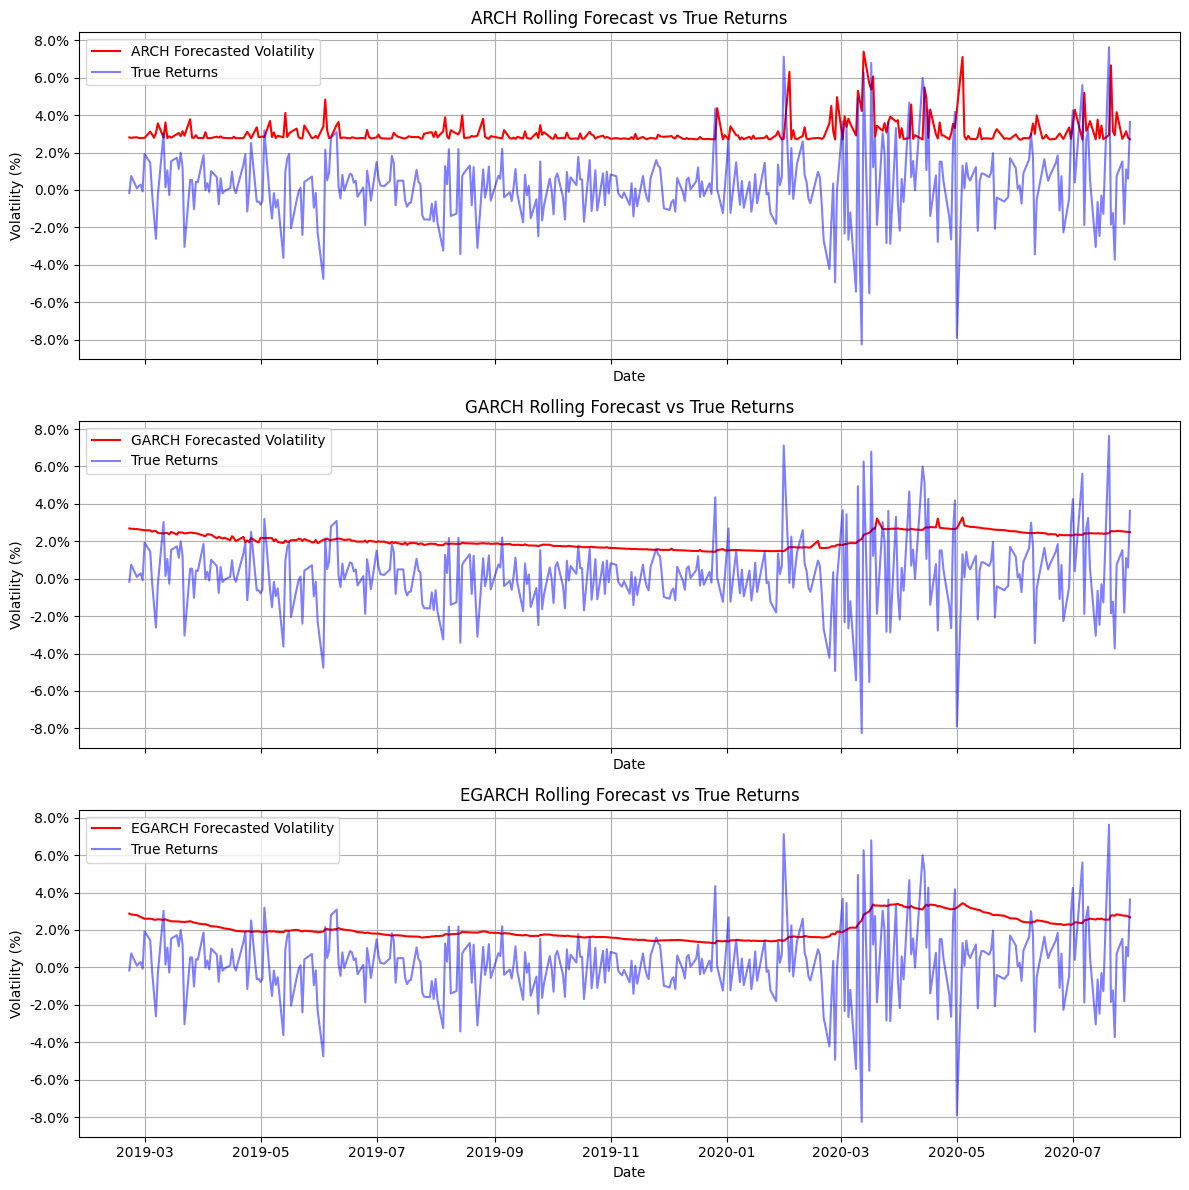

In [124]:
rolling_multi_vol_forecast(returns, test_size=365, p=1, q=1,o=0, dist='normal', vols=['ARCH','GARCH','EGARCH'], plot=True)

### Conclusion: ARCH vs GARCH vs EGARCH (p=1, q=1 except ARCH q=0)

- ARCH (1,0)
    - MAE = 1.96% and RMSE = 2.18%
    - Highest errors, too reactive and unstable.
- GARCH (1,1)
    - MAE = 1.27% and RMSE = 1.53%
    - Lower errors and captures volatility cluster better
- EGARCH (1,1)
    - MAE = 1.26% and RMSE = 1.53%
    - Similar result with GARCH

- ARCH (1,0) reacts sharply to recent shocks but lack of persistence. The volatilities appear to be noisy overtime.

- GARCH (1,1) produces a smoother and stable forecast

- EGARCH (1,1) is similar to GARCH (1,1), but shows a slight response to a negarive shock.

- Both GARCH and EGARCH track real volatility better that ARCH during the high volatility period.

### 2. GARCH Grid Search Function

This function performs a grid search over multiple volatility models. It automatically fits each specification to the given return series and records key model and evaluation metrics such as AIC, BIC and log-likelihood.

In [125]:
def garch_grid_search(returns, 
                      p_range=(1,3), 
                      q_range=(1,3), 
                      dist_list=['normal','t'], 
                      vol_list=['ARCH','GARCH','EGARCH']):
    
    results = []
    returns = returns.dropna()

    for vol in vol_list:
        for p in range(p_range[0], p_range[1] + 1):
            for q in range(q_range[0], q_range[1] + 1):
                for dist in dist_list:
                    try:
                        # ARCH model only uses p (q must be 0)
                        if vol == 'ARCH':
                            model = arch_model(returns, vol=vol, p=p, dist=dist)
                        else:
                            model = arch_model(returns, vol=vol, p=p, q=q, dist=dist)

                        res = model.fit(disp='off')
                        results.append({
                            'vol': vol,
                            'p': p,
                            'q': q if vol != 'ARCH' else 0,
                            'dist': dist,
                            'AIC': res.aic,
                            'BIC': res.bic,
                            'loglik': res.loglikelihood
                        })

                    except Exception as e:
                        print(f"Skipped {vol}(p={p}, q={q}, dist={dist}) -> {e}")

    results_df = pd.DataFrame(results).sort_values(by='AIC').reset_index(drop=True)
    return results_df.head(10)

Inputs:

- `returns` (pd.Series) : Series of asset or log returns (preferably multiplied by 100 for numerical stability).

- `p_range` (tuple, default=(1,3)) : Range of lag orders (p) for the ARCH or GARCH term to test.

- `q_range` (tuple, default=(1,3)) : Range of lag orders (q) for the GARCH term to test (ignored for ARCH models).

- `dist_list` (list, default=['normal','t']) : List of residual distributions to evaluate (e.g., Normal, Student’s t).

- `vol_list` (list, default=['ARCH','GARCH','EGARCH']) : Types of volatility models to test.

Outputs:

- Returns a DataFrame of all fitted model combinations, ranked by AIC (lowest first).


In [126]:
garch_grid_search(returns, 
                  p_range=(1,3), 
                  q_range=(1,3), 
                  dist_list=['normal','t'], 
                  vol_list=['ARCH','GARCH','EGARCH'])

,vol,p,q,dist,AIC,BIC,loglik
0,EGARCH,2,1,t,27642.349,27682.385,-13815.174
1,EGARCH,3,1,t,27643.351,27690.060,-13814.676
2,EGARCH,2,2,t,27644.349,27691.057,-13815.174
3,EGARCH,3,2,t,27645.351,27698.732,-13814.676
4,EGARCH,2,3,t,27646.349,27699.730,-13815.174
5,EGARCH,1,3,t,27646.938,27693.647,-13816.469
6,EGARCH,3,3,t,27647.351,27707.405,-13814.676
7,EGARCH,1,2,t,27648.617,27688.653,-13818.308
8,EGARCH,1,1,t,27656.304,27689.667,-13823.152
9,GARCH,1,3,t,27751.988,27798.697,-13868.994


The grid search compared multiple EGARCH(p, q) configurations ranked by AIC.
### Interpretation

- The EGARCH(2,1) model provides the best overall fit (lowest AIC and BIC) while maintaining a parsimonious structure.

- Increasing lag orders (p or q) does not substantially improve log-likelihood, suggesting no significant additional volatility memory beyond the second ARCH term and first GARCH term.

- All models use the t-distribution, which captures fat-tailed returns more effectively than the normal distribution

### Rolling Forecast Comparison of Top Models

This section performs a rolling one-step-ahead volatility forecast using the five best-performing specifications. The predicted conditional volatilities are compared visually against the actual log returns over the test period.


Running rolling forecast for EGARCH(2,1)...

Running rolling forecast for EGARCH(3,1)...

Running rolling forecast for EGARCH(2,2)...

Running rolling forecast for EGARCH(3,2)...

Running rolling forecast for EGARCH(2,3)...


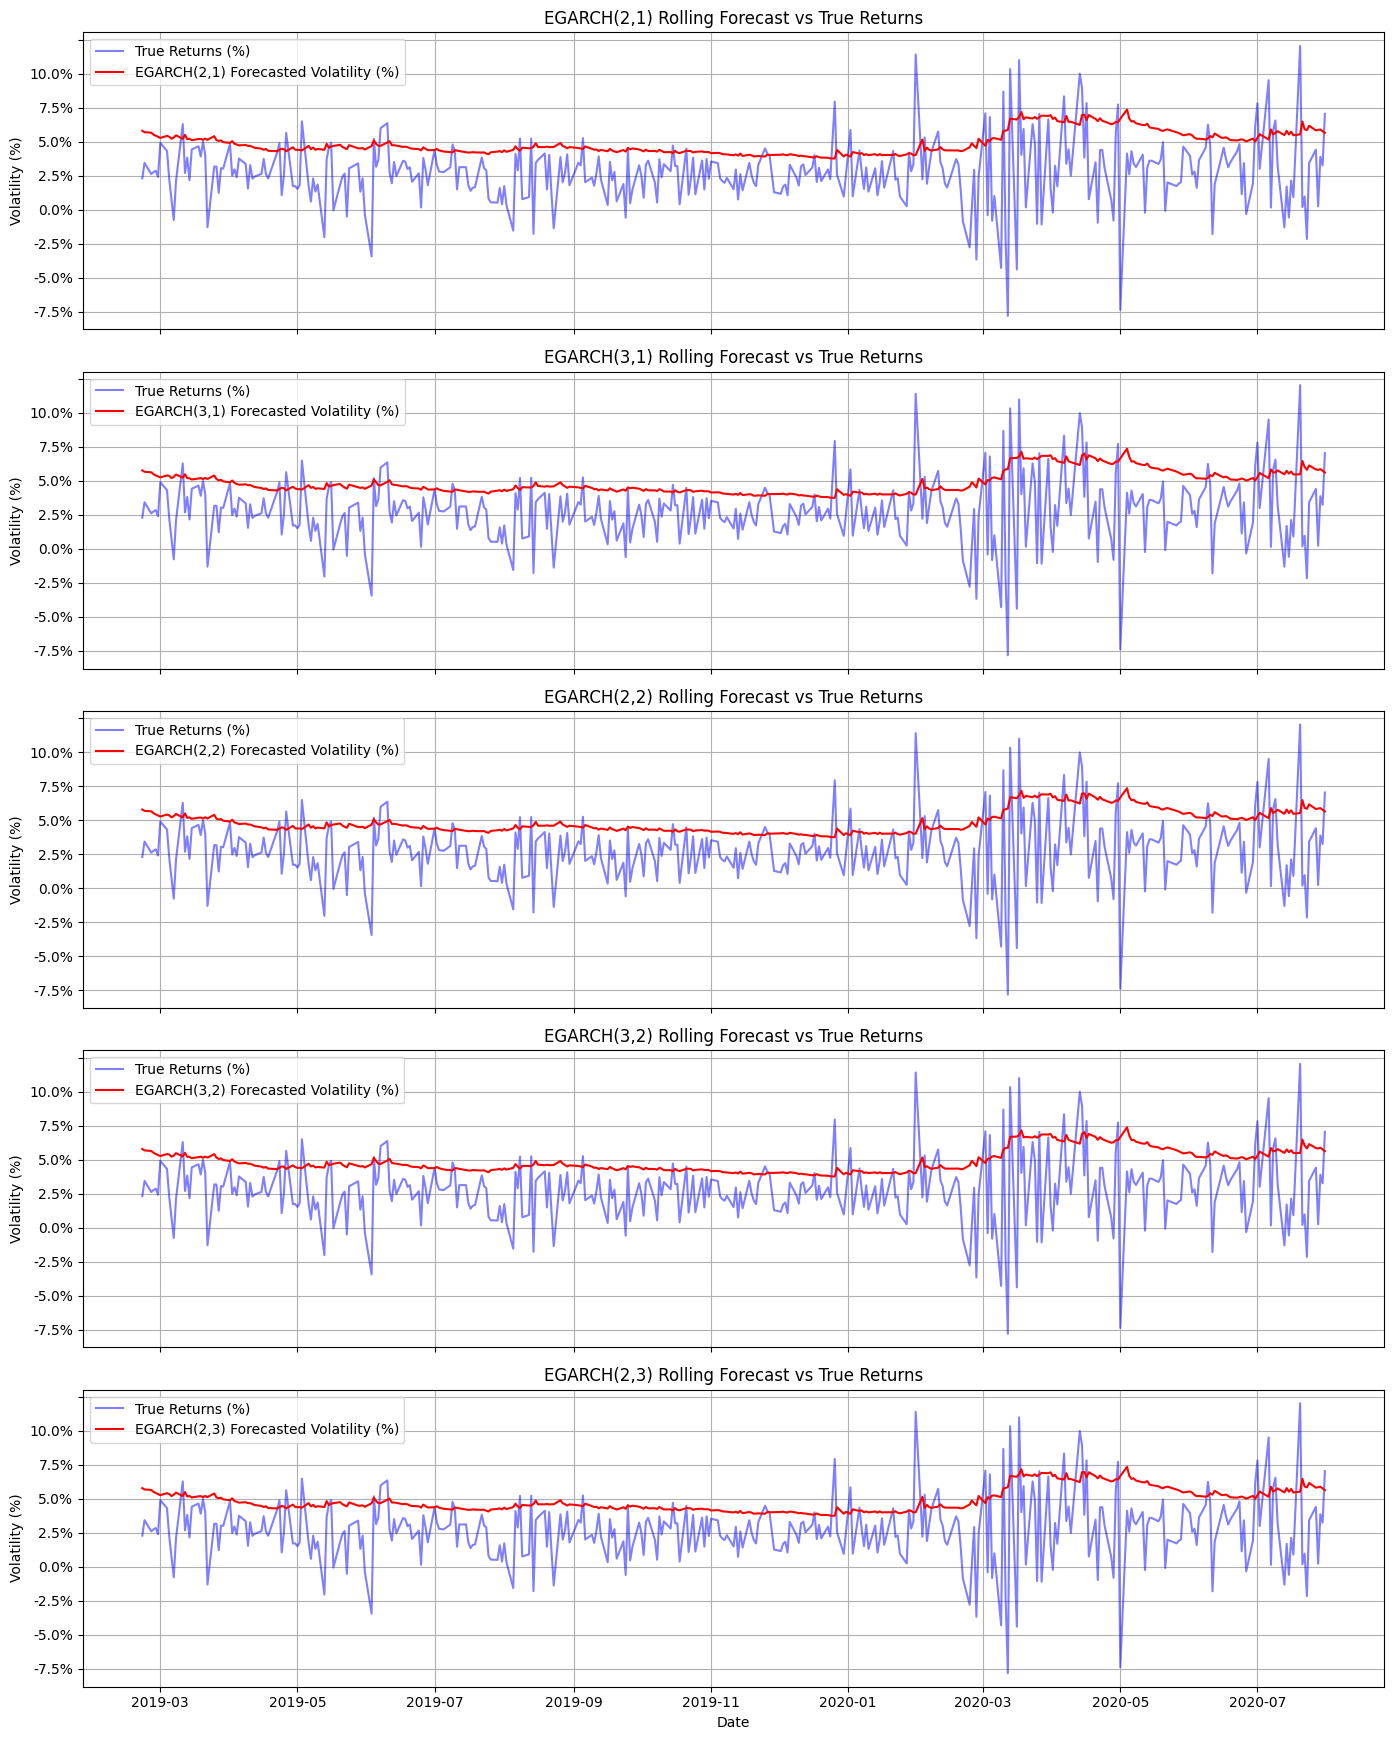

In [127]:
top_models = [
    ('EGARCH(2,1)', dict(vol='EGARCH', p=2, q=1, dist='t')),
    ('EGARCH(3,1)', dict(vol='EGARCH', p=3, q=1, dist='t')),
    ('EGARCH(2,2)', dict(vol='EGARCH', p=2, q=2, dist='t')),
    ('EGARCH(3,2)', dict(vol='EGARCH', p=3, q=2, dist='t')),
    ('EGARCH(2,3)', dict(vol='EGARCH', p=2, q=3, dist='t'))
]

# Rolling forecast for each model
test_size = 365   
returns = df['log_returns'].dropna()
forecasts = {}


for name, spec in top_models:
    print(f"\nRunning rolling forecast for {name}...")
    rolling_preds = []

    
    for i in range(test_size):
        train = returns[:-(test_size - i)]
        try:
            fitted = arch_model(train, mean='Constant', **spec, rescale=True).fit(disp='off')
            fc = fitted.forecast(horizon=1, reindex=True)
            pred_vol = np.sqrt(fc.variance.values[-1,:][0] / 10000) * 100
            rolling_preds.append(pred_vol)
        except Exception as e:
            rolling_preds.append(np.nan)
            print(f"Skipped {name} at step {i}: {e}")

    forecasts[name] = pd.Series(rolling_preds, index=returns[-test_size:].index)

# --- Plot results
n_models = len(top_models)
fig, axes = plt.subplots(n_models, 1, figsize=(14, 3.5 * n_models), sharex=True)

for ax, (name, preds) in zip(axes, forecasts.items()):
    ax.plot(returns[-test_size:].index, returns[-test_size:]*100, color='blue', alpha=0.5, label='True Returns (%)')
    ax.plot(preds.index, preds*10, color='red', label=f'{name} Forecasted Volatility (%)')
    ax.set_title(f'{name} Rolling Forecast vs True Returns')
    ax.set_ylabel('Volatility (%)')
    ax.legend()
    ax.grid(True)
    yticks = ax.get_yticks()
    ax.set_yticklabels([f"{y:.1f}%" for y in yticks])
    axes[-1].set_xlabel('Date')


plt.tight_layout()
plt.show()

Conclusion

- All EGARCH models successfully model time-varying volatility and react to shocks.

- Forecasted volatilities remain stable during calm periods and rise during crisis periods — indicating a good fit.

- The EGARCH(2,1) or EGARCH(2,2) models look sufficient; more parameters add little improvement.

- The scale alignment (returns vs volatility) is now correct — the red line (1–3 %) lies realistically below the blue swings (up to ±7 %).

---

### LSTM

Long Short-Term Memory (LSTM) is a deep learning model specialized for sequential data such as stock prices. It captures long-term patterns and nonlinear relationships better than traditional time-series models like ARIMA or GARCH. In this project, LSTM is used to forecast future prices using normalized historical data and evaluate its predictive performance.

- Part 1: The baseline model is implemented with two LSTM layers (50 neurons each), Dropout(0.2) to prevent overfitting, and a Dense output layer for final prediction.
- Part 2: A grid search is later conducted to fine-tune the hyperparameters to improve the model’s predictive performance.

### Model Preparation

In [128]:
# Scale the 'Close' prices between 0 and 1
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_price = scaler.fit_transform(price)
scaled_df = pd.DataFrame(scaled_price, index =price.index, columns = ['Scaled_Close'] )

In [129]:
# Train-test split
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

### Sequence Creating Function

This function is designed to prepare sequential data for training a long short term memory model. In time-series forecasting, LSTMs require input data in the form of fixed length sequences.

In [130]:
# Function to create sequences for LSTM
def create_sequences(data, size =60):
    X, y = [], []
    for i in range(size, len(data)):
        X.append(data[i-size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

### Input 

`data` : The original time series data in `numpy.ndarray`

`size` : The length of each input sequential.

### Output

`X` : Array of x.

`y` : Array of y.

In [131]:
# Create sequences of x_train, x_test and y_train, y_test
x_train, y_train = create_sequences(train_data.values, size=60)
x_test, y_test = create_sequences(test_data.values, size=60)

# Reshape x_train and x_test
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

### 1. LSTM Baseline model

In [132]:
# Build the LSTM model
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
history =model.fit(x_train,y_train,batch_size=32, epochs=50, validation_data=(x_test,y_test),verbose=1)

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.2658e-04 - val_loss: 5.2236e-04
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 3.0943e-05 - val_loss: 4.5374e-04
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.5018e-05 - val_loss: 5.9108e-04
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.5302e-05 - val_loss: 3.8801e-04
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.0658e-05 - val_loss: 4.5513e-04
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.3255e-05 - val_loss: 4.2900e-04
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.4672e-05 - val_loss: 3.2251e-04
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.9593e-05 - val_loss: 3.5854e-04
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.1666e-05 - val_loss: 3.1253e-04
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 2.2609e-05 - val_loss: 4.1184e-04
Epoch 11/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/

The model contains:
- 3 trainable layers : 2 LSTM + 1 DENSE
- 2 regularization layers : 2 dropouts

Total 5 layers in the network.

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


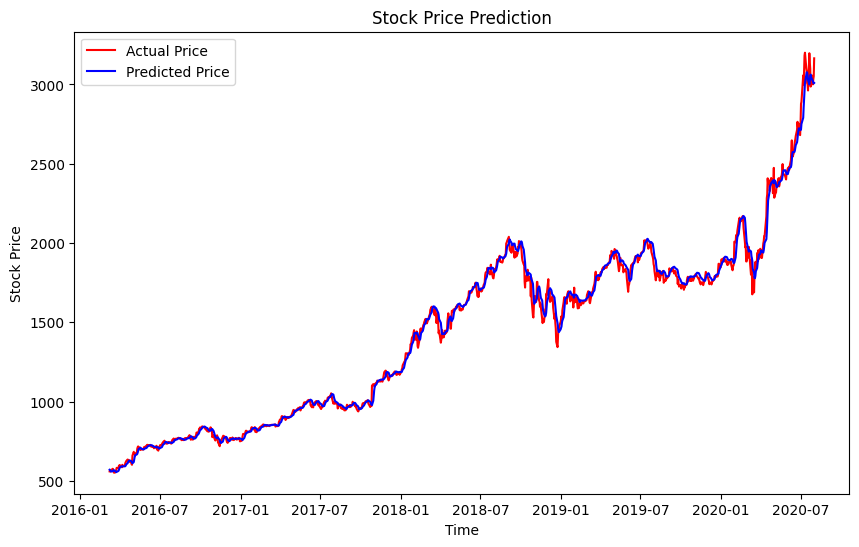

In [133]:
# Predict on x test
pred_scaled = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_scaled.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
test_index = df.index[-len(y_test):]

# plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(test_index, y_test_actual, color='red', label='Actual Price')
plt.plot(test_index, pred_price, color='blue', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Interpretation:

- The blue line follows the red line closely, showing that LSTM captures the overall trend and seasonality of the stock price.

- The model performs especially well during stable and gradual growth periods.

- Some deviation appear during the sharp increases in 2018 and 2020, where the model slighly underestiamated a rise in price.

- LSTM demostrates strong forecasting consistency.

In [134]:
# Prediction Evaluation
print("LSTM Model Performance:")
print("="*60)
print(f" MAE: {mean_absolute_error(y_test_actual, pred_price):.2f}")
print(f" RMSE: {root_mean_squared_error(y_test_actual, pred_price):.2f}")
print(f" Mean of test set: {y_test_actual.mean():.2f}")

LSTM Model Performance:
 MAE: 27.79
 RMSE: 43.86
 Mean of test set: 1439.78


### Interpretation

- MAE of 88.03 shows that the model predicion, on average, differ from actual stock price around 88.

- RMSE of 107.14 is slightly higher than MAE, indicating that some larger prediction errors exist

- Comparing these erros to the mean stock price, the model's erros is around 6-7%.

---

### 2. LSTM  Hyperparameter Tunning

To improve model performance, different configurations of LTSM are tested. This process helps to identify the set up that minimizes MAE and RMSE by adjusting hyperparameter.

In [135]:
results = []

# loop through different hyperparameter combinations
for u in [50,80,100]:
    for d in [0.1,0.2,0.3]:
        model = Sequential([
            LSTM(units=u, return_sequences=True, input_shape=(x_train.shape[1], 1)),
            Dropout(d),
            LSTM(units=u, return_sequences=False),
            Dropout(d),
            Dense(units=1)
        ])

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(x_train,y_train,batch_size=32, epochs=30, validation_data=(x_test,y_test),verbose=0)

        pred_scaled = model.predict(x_test)
        pred_price = scaler.inverse_transform(pred_scaled.reshape(-1,1))
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

        rmse = root_mean_squared_error(y_test_actual, pred_price)
        mae = mean_absolute_error(y_test_actual, pred_price)

        results.append({
            'Units': u,
            'Dropout': d,
            'RMSE': round(rmse, 2),
            'MAE': round(mae, 2)
        })

results_df = pd.DataFrame(results).sort_values(by='RMSE').reset_index(drop=True)
print("LSTM Hyperparameter Tuning Results:")
print("="*60)
print(results_df)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM Hyperparameter Tuning Results:
   Units  Dropout   RMSE    MAE
0     80    0.200 41.280 26.890
1     80    0.100 42.240 27.460
2    100    0.200 47.420 34.000
3     50    0.200 50.310 33.180
4     50    0.100 50.900 35.160
5    100    0.300 53.500 40.000
6     50    0.300 82.320 66.750
7     80    0.300 90.080 72.540
8    100    0.100 90.080 70.180


### Interpretation

- The best model configuration is 50 units with a dropout rates of 0.1, achieving
    - MAE = 26.89
    - RMSE = 41.28
    
- Increasing the number of units more does imporve the model performance.

- Similarly, increasing dropout rate generally improves erros.

- The result indicates that a simpler LSTM configuration genertates teh best result for this dataset.

In [141]:
# run the best model
np.random.seed(42)

model = Sequential([
    LSTM(units=80, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.1),
    LSTM(units=80, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train,batch_size=32, epochs=50, validation_data=(x_test,y_test),verbose=1)

Epoch 1/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 9.8656e-05 - val_loss: 5.3765e-04
Epoch 2/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.2525e-05 - val_loss: 3.9519e-04
Epoch 3/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 2.2041e-05 - val_loss: 3.9389e-04
Epoch 4/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.9335e-05 - val_loss: 7.9171e-04
Epoch 5/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.9051e-05 - val_loss: 3.7815e-04
Epoch 6/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.6510e-05 - val_loss: 7.8380e-04
Epoch 7/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.5350e-05 - val_loss: 3.3964e-04
Epoch 8/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.8580e-05 - val_loss: 8.0432e-04
Epoch 9/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.3997e-05 - val_loss: 8.7836e-04
Epoch 10/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 1.5401e-05 - val_loss: 4.4032e-04
Epoch 11/50
145/145 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


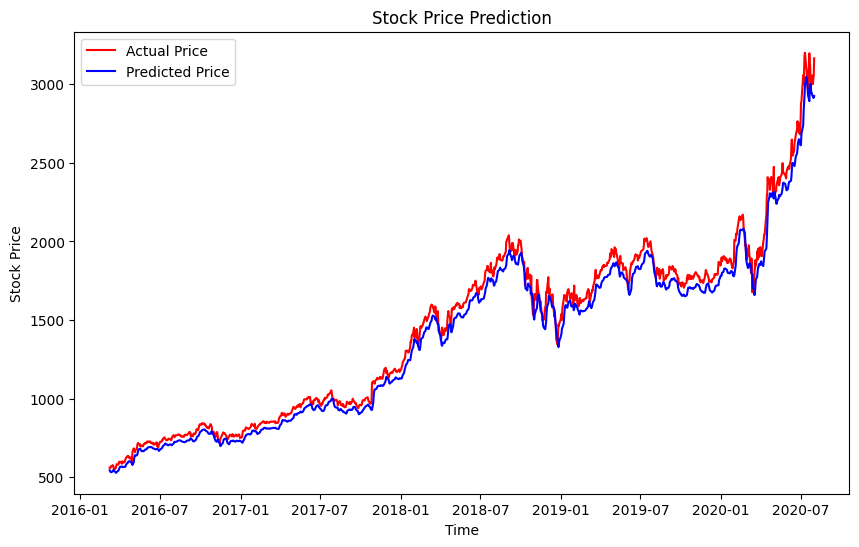

In [142]:
# Predict on test set
pred_scaled = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_scaled.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))
test_index = df.index[-len(y_test):]

# plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(test_index, y_test_actual, color='red', label='Actual Price')
plt.plot(test_index, pred_price, color='blue', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### Interpretation

- The blue predicted curve almost overlaps with the red actual curve, indicating a high accuracy.

- The model sucessfully learns both long-term upward trends and short-term variations.

- During the rapid growth in 2018 and 2020, LSTM model effectively track these variations.

- The close alignment between actual and predicted lines demonstrates that the model has captured the temporal dependencies in stock prices well.

### Predict Future with LSTM model

In [139]:
# Forecasting for the next 30 days
last_sequence = scaled_df['Scaled_Close'].values[-60:]
future_predictions = []

for i in range(30):
    pred = model.predict(last_sequence.reshape(1, 60, 1),verbose=0)
    future_predictions.append(pred[0,0])

    last_sequence = np.append(last_sequence[1:], pred[0,0])


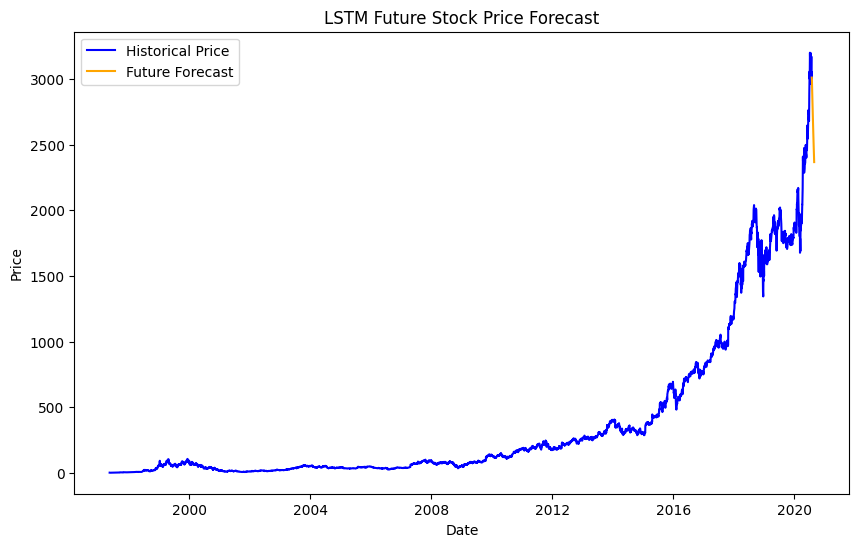

In [140]:
# Plot the forcasting for the next 30 days
future_steps = 30
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps)

# 5. Plot
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Close'], label='Historical Price', color='blue')
plt.plot(future_dates, future_predictions, label='Future Forecast', color='orange')
plt.title('LSTM Future Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### LSTM Future Stock Price Forecast — Summary

The LSTM model was trained on the historical stock prices using a 60-day lookback window to capture temporal dependencies in the data.  
The plot above shows that the **predicted future prices (orange line)** smoothly extend from the **historical trend (blue line)**, indicating that the model has successfully learned the underlying short term patterns in the stock movements.

Overall, the result demonstrates that:

- The LSTM model captures short term temporal structure well.

- Predictions align closely with recent observed prices, confirming consistent scaling and model stability.

# 5. Conclusion 

1. Summary of the study

This project aimed to forecast the AMAZON stock price movement uisng multiple time series models to compare their predictive capabilitites and understand which approach best capture both long and short term variations in this data.

2. Overall Evaluations

- Both ARIMA and SARIMA were less effective in capturing short-term market shocks or sudden upward movements. This limitation occurs because ARIMA-type models assume linear relationships and are less adaptable to rapidly changing patterns

- The GARCH model successfully captures the time varying volatility in the stock returns. It demonstrates strong performance in identifying volatility clustering, making it valuable for analyzing risk dynamics even though it does not directly predict price levels.'

- LSTM model demonstrates superior performance in forecasting stock prices on the test data compared to traditional statistical models. It effectively captures both long term trends and shortterm fluctuations, producing predictions that closely follow the actual price movements over time. The model achieves the lowest MAE and RMSE, confirming its ability to generalize well and maintain high predictive accuracy.

3. Final Remark

Among all tested models, the LSTM demonstrated the most accurate forecasting performance, achieving the lowest MAE and RMSE, and closely following the actual stock price movements.
While ARIMA and SARIMA offered interpretable insights into long-term trends and GARCH effectively modeled volatility behavior, the LSTM captured complex nonlinear dynamics that traditional statistical models could not.

In future work, combining the interpretability of GARCH or ARIMA models with the predictive strength of LSTM through hybrid modeling could further enhance accuracy and robustness.
